# Analysis

> **VWAP** tells you “where price really traded.”  
> **Sentiment** tells you “what investors were reading” and “how they would react.”

**Objective:**  
Assess whether daily news-sentiment (“score”) can predict next-day intraday price behavior (VWAP returns) for large-cap stocks.


# 1. Data Loading & Overview

Load the data, show its shape, and peek at the first few rows.

Initially, I gathered daily news‐sentiment scores and financial data for only three stocks.  
Realizing this dataset was too limited, I expanded the sample to 17 stocks across multiple industries.


In [50]:
# load required packages
import os
import numpy as np
import pandas as pd
import calendar
import matplotlib.pyplot as plt
from google.colab import drive
from datetime import datetime, timedelta
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
import scipy.stats as stats
from scipy.stats import f_oneway
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit
import warnings
warnings.filterwarnings('ignore')


# access drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Sentimental/'
records_path = os.path.join(path, 'data', 'records.csv')

# get stock list
stocks = pd.read_csv(os.path.join(path, 'data', 'stock_list.csv'), index_col = 0)
stock_lst = [[company, stocks.loc[company, 'stock_code']] for company in stocks.index]
stocks

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,stock_code
apple,AAPL
tesla,TSLA
nvidia,NVDA
microsoft,MSFT
amazon,AMZN
google,GOOGL
meta,META
netflix,NFLX
disney,DIS
visa,V


## Stock Groups by Industry

- **Technology**  
  - Apple (AAPL)  
  - Nvidia (NVDA)  
  - Microsoft (MSFT)  

- **Communication Services**  
  - Google (GOOGL)  
  - Meta Platforms (META)  
  - Netflix (NFLX)  
  - Disney (DIS)  

- **Consumer Discretionary**  
  - Amazon (AMZN)  
  - Tesla (TSLA)  
  - Home Depot (HD)  

- **Financials**  
  - Visa (V)  
  - Mastercard (MA)  
  - JPMorgan Chase & Co. (JPM)  
  - Bank of America (BAC)  

- **Healthcare**  
  - Johnson & Johnson (JNJ)  
  - UnitedHealth Group (UNH)  
  - Pfizer (PFE)  


In [51]:
# load data
records_path = os.path.join(path, 'data', 'records.csv')
df = pd.read_csv(records_path,na_values=['null_val'])
df.head()

,date,company,stock,datetime,title,news,link,open,high,low,close,volume,vwap,transactions,gpt_response,score
0,20250422,apple,AAPL,2025-04-22 12:42:20+00:00,Survey Shows Pent-Up Demand For New Apple iPhones,A survey of U.S. consumers in March indicates ...,https://finance.yahoo.com/m/f862527e-fa7e-335a...,196.12,201.59,195.97,198.91,25860823.0,198.8815,386273.0,Score: 4. Reasoning: The news indicates a stro...,4.0
1,20250422,apple,AAPL,2025-04-22 10:42:04+00:00,Apple Intelligence Gains Momentum as Users Sho...,Apple (NASDAQ:AAPL) might be winning over more...,https://finance.yahoo.com/news/apple-intellige...,196.12,201.59,195.97,198.91,25860823.0,198.8815,386273.0,Score: 4. Reasoning: The overall sentiment tow...,4.0
2,20250422,apple,AAPL,2025-04-22 10:02:00+00:00,"Sell Apple stock before it sinks another 30%, ...",Photo: Sean Gallup (Getty Images)\n\nA firm th...,https://finance.yahoo.com/news/sell-apple-stoc...,196.12,201.59,195.97,198.91,25860823.0,198.8815,386273.0,Score: -4. Reasoning: The financial news respo...,-4.0
3,20250422,apple,AAPL,2025-04-22 09:44:36+00:00,Apple (AAPL) Target Slashed to $141: ‘No Easy ...,We recently published a list of Top 10 AI Stoc...,https://finance.yahoo.com/news/apple-aapl-targ...,196.12,201.59,195.97,198.91,25860823.0,198.8815,386273.0,Score: -2. Reasoning: The sentiment towards Ap...,-2.0
4,20250422,apple,AAPL,2025-04-22 08:37:51+00:00,Cloud AI Update - Tonita Unveils AI Shopping A...,Tonita has launched a new AI-driven shopping a...,https://finance.yahoo.com/news/cloud-ai-tonita...,196.12,201.59,195.97,198.91,25860823.0,198.8815,386273.0,Score: 2. Reasoning: The overall sentiment tow...,2.0


# 2. Data cleaning

Drop weekends/holidays (rows where VWAP or score is null).

In [52]:
# Count of missing values in each column
df.isnull().sum()

,0
date,0
company,0
stock,0
datetime,0
title,0
news,0
link,0
open,1991
high,1991
low,1991


In [53]:
# since weekend do not have trade record and any other value
# we just drop it and focused on the trade day
# also drop holiday
df = df.dropna()

In [54]:
# check duplicates because news api sometimes will have duplicates
dup_counts = (
    df
    .groupby('company')['news']
    .apply(lambda x: x.duplicated().sum())
    .reset_index(name='dup_count')
)
dup_counts

,company,dup_count
0,amazon,7
1,apple,7
2,bank of america,0
3,disney,2
4,google,8
5,home depot,1
6,johnson & johnson,2
7,jpmorgan chase & co.,2
8,mastercard,1
9,meta,3


In [55]:
df = df.drop_duplicates(subset=['company', 'news'], keep='first')
# verify no duplicates remain
dup_counts_after = (
    df
    .groupby('company')['news']
    .apply(lambda x: x.duplicated().sum())
    .reset_index(name='dup_count')
)
dup_counts_after

,company,dup_count
0,amazon,0
1,apple,0
2,bank of america,0
3,disney,0
4,google,0
5,home depot,0
6,johnson & johnson,0
7,jpmorgan chase & co.,0
8,mastercard,0
9,meta,0


In [56]:
df['date'] = pd.to_datetime(df['date'].astype(str), format='%Y%m%d')
df['datetime'] = pd.to_datetime(df['datetime'].astype(str), utc=True)
# sort by company (to group tickers together) and date descending
df = (
    df
    .sort_values(['company', 'datetime'], ascending=[True, True])
    .reset_index(drop=True)
)
df

,date,company,stock,datetime,title,news,link,open,high,low,close,volume,vwap,transactions,gpt_response,score
0,2025-03-18,amazon,AMZN,2025-03-18 14:43:01+00:00,Nvidia unveils Blackwell Ultra AI chip for 'ag...,Nvidia (NVDA) CEO Jensen Huang announced the c...,https://finance.yahoo.com/news/nvidia-unveils-...,192.52,194.00,189.38,192.82,40412937.0,192.0851,554392.0,Score: 4. Reasoning: The news highlights Nvidi...,4.0
1,2025-03-18,amazon,AMZN,2025-03-18 14:43:05+00:00,Nvidia debuts next-generation Vera Rubin super...,Nvidia (NVDA) gave the world a sneak peek at i...,https://finance.yahoo.com/news/nvidia-debuts-n...,192.52,194.00,189.38,192.82,40412937.0,192.0851,554392.0,Score: 3. Reasoning: The news about Nvidia deb...,3.0
2,2025-03-18,amazon,AMZN,2025-03-18 15:03:35+00:00,The 'Magnificent 7' stocks are having their wo...,Tuesday's stock market sell-off had a familiar...,https://finance.yahoo.com/news/the-magnificent...,192.52,194.00,189.38,192.82,40412937.0,192.0851,554392.0,Score: -3. Reasoning: The sentiment towards Am...,-3.0
3,2025-03-18,amazon,AMZN,2025-03-18 17:06:58+00:00,FTC Sues Click Profit Over Alleged Amazon Inve...,The Federal Trade Commission (FTC) is taking l...,https://finance.yahoo.com/news/ftc-sues-click-...,192.52,194.00,189.38,192.82,40412937.0,192.0851,554392.0,Score: -5. Reasoning: The news highlights a ne...,-5.0
4,2025-03-18,amazon,AMZN,2025-03-18 17:15:00+00:00,"Stalling rally, Magnificent 7 vs. ARKK, gold: ...","US stocks (^DJI, ^IXIC, ^GSPC) capped off Tues...",https://finance.yahoo.com/video/stalling-rally...,192.52,194.00,189.38,192.82,40412937.0,192.0851,554392.0,Score: -3. Reasoning: The news highlights a st...,-3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12947,2025-04-29,visa,V,2025-04-29 17:06:19+00:00,"Visa Stock: Dow Giant Clears Q2 Views, Lauds ""...",Visa stock rose in late trade Tuesday after th...,https://finance.yahoo.com/m/785ae5ce-bc2e-35db...,338.50,342.27,336.46,341.52,5517264.0,340.3798,108517.0,Score: 4. Reasoning: Overall sentiment towards...,4.0
12948,2025-04-29,visa,V,2025-04-29 17:15:09+00:00,Visa (V) Surpasses Q2 Earnings and Revenue Est...,Visa (V) came out with quarterly earnings of $...,https://finance.yahoo.com/news/visa-v-surpasse...,338.50,342.27,336.46,341.52,5517264.0,340.3798,108517.0,Score: 4. Reasoning: The overall sentiment tow...,4.0
12949,2025-04-29,visa,V,2025-04-29 18:46:00+00:00,Visa Maintains Outlook Amid ‘Resilient’ Consum...,Visa offered mixed financial results on Tuesda...,https://finance.yahoo.com/m/66b040b3-e71a-314a...,338.50,342.27,336.46,341.52,5517264.0,340.3798,108517.0,Score: 3. Reasoning: Overall positive sentimen...,3.0
12950,2025-04-29,visa,V,2025-04-29 19:00:11+00:00,"Compared to Estimates, Visa (V) Q2 Earnings: A...","For the quarter ended March 2025, Visa (V) rep...",https://finance.yahoo.com/news/compared-estima...,338.50,342.27,336.46,341.52,5517264.0,340.3798,108517.0,Score: 4. Reasoning: The sentiment towards Vis...,4.0


Now examine the spread of the news

In [57]:
df['year']  = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df2 = df[df['year'].isin([2024, 2025])]
counts_2024 = (
    df2[df2['year']==2024]
    .groupby(['stock','month'])
    .size()                     # count rows
    .unstack(fill_value=0)      # make months into columns
    .sort_index(axis=1)         # ensure months run 1→12
)
# rename numeric months to Jan…Dec using calendar
counts_2024.columns = [calendar.month_abbr[m] for m in counts_2024.columns]

# for 2025
counts_2025 = (
    df2[df2['year']==2025]
    .groupby(['stock','month'])
    .size()
    .unstack(fill_value=0)
    .sort_index(axis=1)
)
counts_2025.columns = [calendar.month_abbr[m] for m in counts_2025.columns]
print("---- 2024 counts per stock per month ----")
print(counts_2024)

print("\n---- 2025 counts per stock per month ----")
print(counts_2025)

---- 2024 counts per stock per month ----
       Feb  Mar  Apr  May  Jun  Jul  Aug  Sep  Oct  Nov  Dec
stock                                                       
BAC      0    0    0    0    0   24   90  110   86    4    9
DIS      0    0    0    0    0  106  161   69   54   10   10
HD      10   45   53   92   44   57   85   39   34    7    6
JNJ      0    0    0    0   53   97   73   63   65    2    4
JPM      0    0    0    0    0    0    0    0  122    5   10
MA       0   22   64   83   74   74   64   68   36    5   13
NFLX     0    0    0    0    0    0    0    0   51   22   27
PFE      0    0    0    0    0    0   98   94  104    9    9
UNH      0    0   11   52   59   95   43   49   40    4   27
V        0    0    0    0    0   69   86   92   74   35   48

---- 2025 counts per stock per month ----
       Jan  Feb  Mar  Apr
stock                    
AAPL     0    0  204  638
AMZN     0    0  189  601
BAC     91   78   76  147
DIS     51  103   68   76
GOOGL    0    0  217  581
H

**Note on Data Coverage:**  
Because the API caps each request at 1,000 articles, date ranges differ by ticker:  
- **Highly popular stocks** generate so many recent articles that the 1,000-item limit only reaches into _recent_ days.  
- **Less popular stocks** produce fewer articles, so the API returns stories dating back into _last_ year.  

Although these spans don’t align perfectly, it won’t bias our results: we’ll analyze each ticker’s sentiment–VWAP relationship independently, grouping by company and then examining next-day intraday VWAP returns against daily sentiment scores.



## Let’s View the Overall Plot First  


AMAZON stats:
            score        vwap
count  790.000000  790.000000
mean     0.845570  185.314929
std      3.273576    9.283000
min     -5.000000  166.925500
25%     -3.000000  180.342600
50%      3.000000  184.880100
75%      4.000000  191.470100
max      5.000000  205.103700 



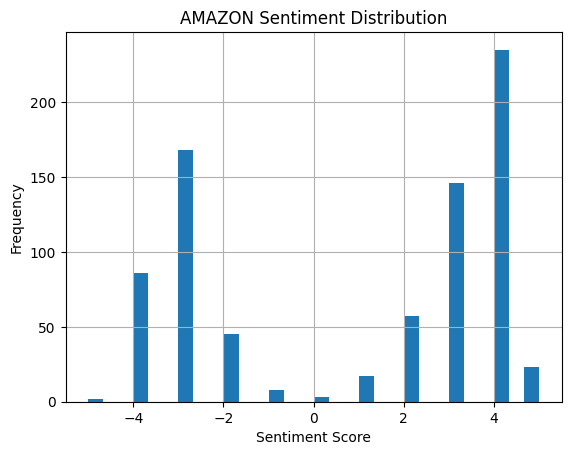


APPLE stats:
            score        vwap
count  842.000000  842.000000
mean     0.002375  203.554929
std      3.309626   12.945264
min     -5.000000  179.073800
25%     -3.000000  192.554400
50%     -0.500000  205.360200
75%      3.000000  213.253600
max      5.000000  223.372900 



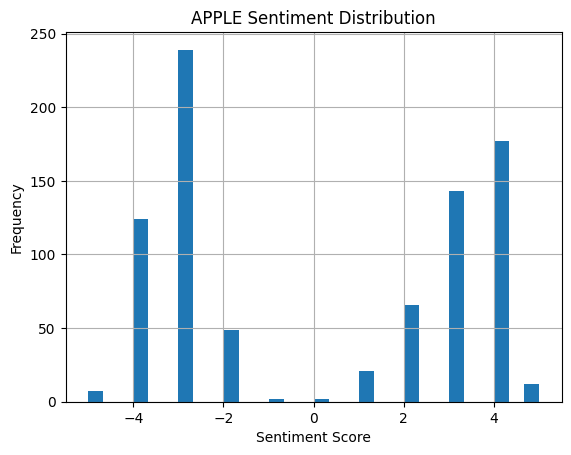


BANK OF AMERICA stats:
            score        vwap
count  715.000000  715.000000
mean     1.240559   41.269142
std      3.137517    3.416659
min     -5.000000   34.492600
25%     -3.000000   39.018750
50%      3.000000   40.087800
75%      4.000000   44.007050
max      5.000000   47.794900 



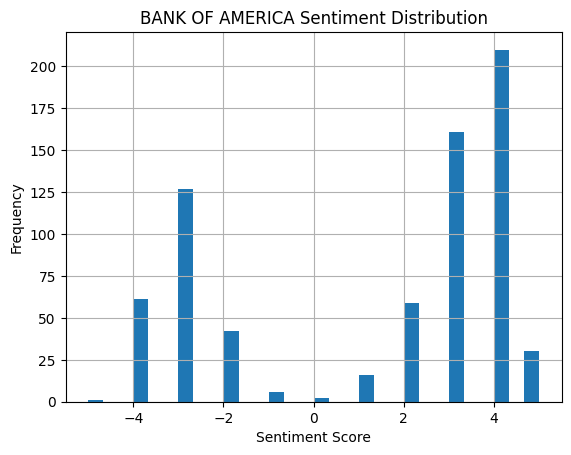


DISNEY stats:
            score        vwap
count  708.000000  708.000000
mean     0.896893   96.854856
std      3.199512    9.546921
min     -5.000000   82.927500
25%     -3.000000   89.484675
50%      3.000000   94.177200
75%      4.000000  107.216000
max      5.000000  117.301400 



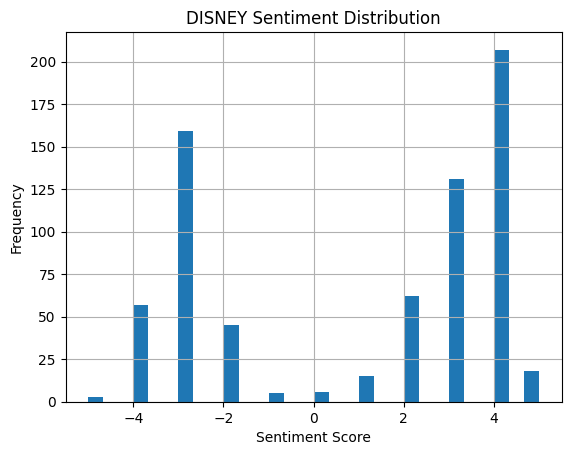


GOOGLE stats:
            score        vwap
count  798.000000  798.000000
mean     0.904762  159.236199
std      3.278147    6.100395
min     -5.000000  148.137500
25%     -3.000000  153.783200
50%      3.000000  158.439900
75%      4.000000  165.001400
max      5.000000  172.181100 



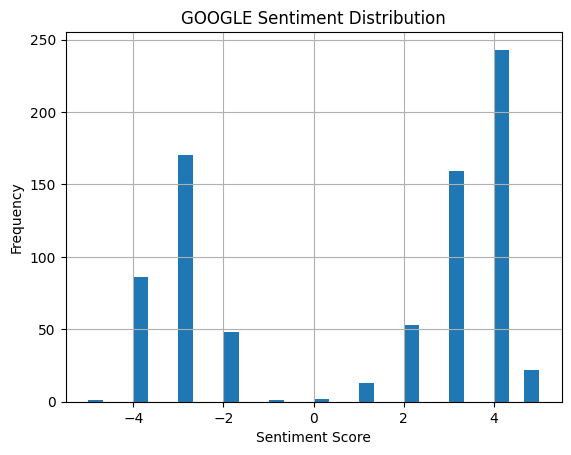


HOME DEPOT stats:
            score        vwap
count  710.000000  710.000000
mean     1.642254  368.354018
std      2.913693   26.209104
min     -4.000000  325.628300
25%     -2.000000  345.934700
50%      3.000000  362.898800
75%      4.000000  391.794350
max      5.000000  428.006300 



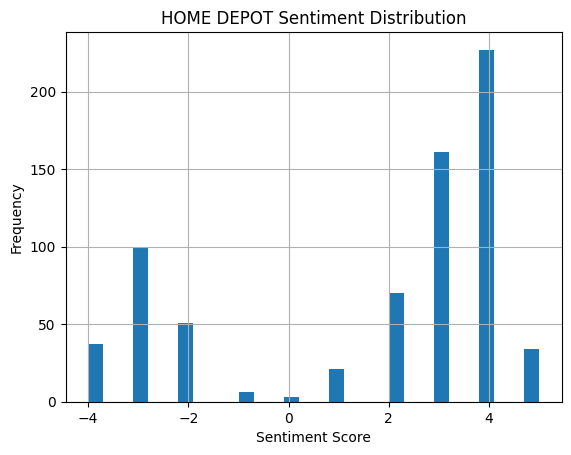


JOHNSON & JOHNSON stats:
            score        vwap
count  699.000000  699.000000
mean     1.998569  156.446353
std      2.931158    7.088186
min     -5.000000  143.872800
25%      1.000000  150.081300
50%      3.000000  156.494100
75%      4.000000  162.958950
max      5.000000  168.372200 



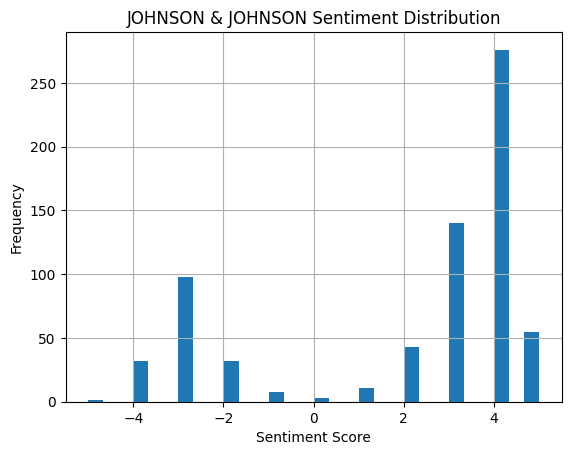


JPMORGAN CHASE & CO. stats:
            score        vwap
count  728.000000  728.000000
mean     0.980769  241.277588
std      3.287200   20.203372
min     -5.000000  205.200400
25%     -3.000000  225.869200
50%      3.000000  235.477300
75%      4.000000  261.881900
max      5.000000  279.187000 



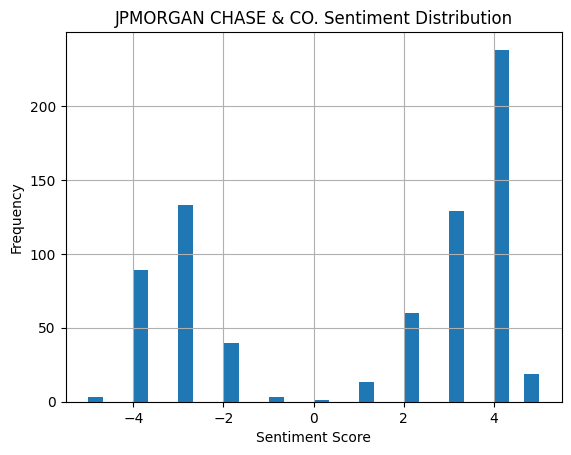


MASTERCARD stats:
            score        vwap
count  713.000000  713.000000
mean     2.503506  487.582639
std      2.590562   40.575910
min     -4.000000  431.913800
25%      2.000000  452.931300
50%      4.000000  476.849600
75%      4.000000  523.768300
max      5.000000  576.447600 



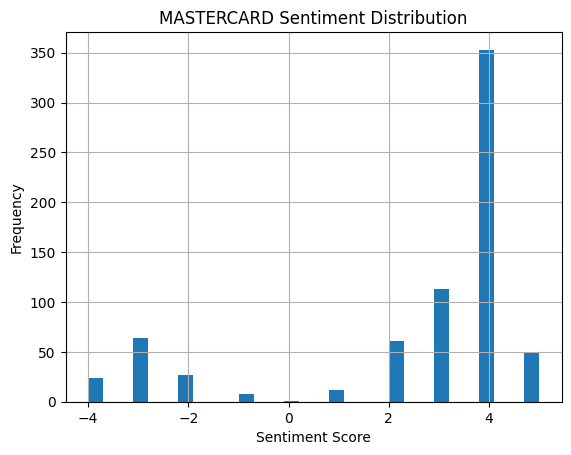


META stats:
            score        vwap
count  759.000000  759.000000
mean     0.379447  573.513675
std      3.298420   52.461957
min     -5.000000  484.893500
25%     -3.000000  525.842500
50%      2.000000  552.246300
75%      4.000000  614.623300
max      5.000000  673.893500 



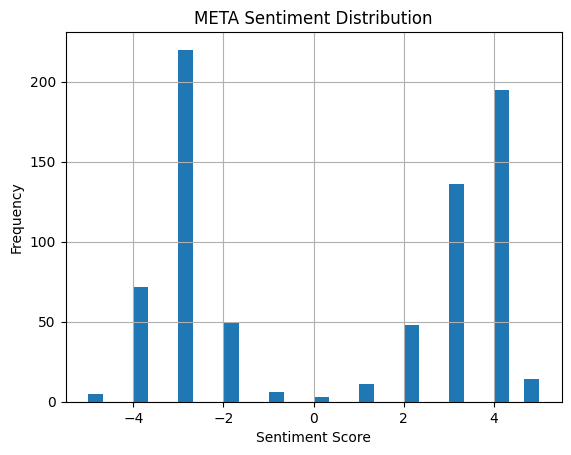


MICROSOFT stats:
            score        vwap
count  785.000000  785.000000
mean     0.992357  382.371608
std      3.154191   10.043671
min     -5.000000  356.019700
25%     -3.000000  376.157600
50%      3.000000  383.421300
75%      4.000000  390.247800
max      5.000000  397.222500 



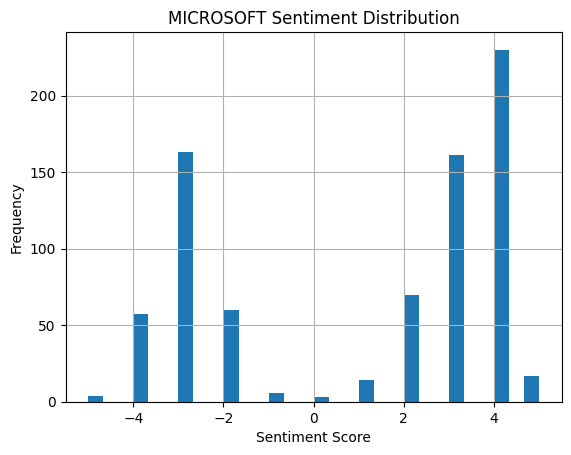


NETFLIX stats:
            score         vwap
count  668.000000   668.000000
mean     2.663174   945.126986
std      2.468760    82.459028
min     -5.000000   696.597800
25%      3.000000   904.281400
50%      4.000000   969.737900
75%      4.000000   981.159000
max      5.000000  1115.183900 



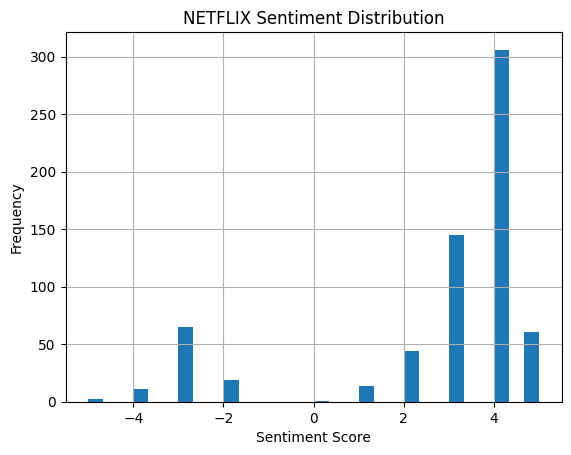


NVIDIA stats:
            score        vwap
count  876.000000  876.000000
mean     0.526256  104.762637
std      3.369170    4.901908
min     -5.000000   94.899500
25%     -3.000000  101.653800
50%      2.000000  103.827800
75%      4.000000  108.922700
max      5.000000  111.697100 



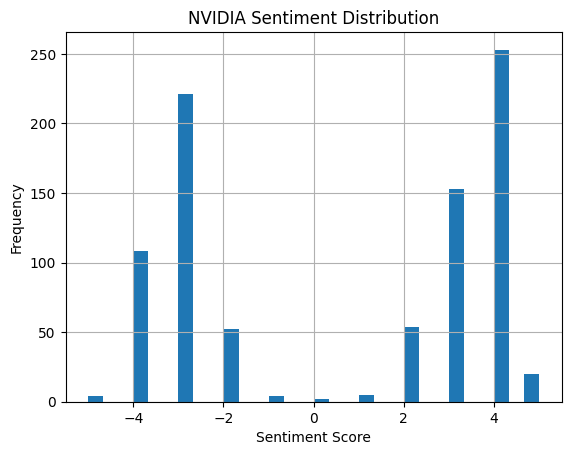


PFIZER stats:
            score        vwap
count  748.000000  748.000000
mean     1.306150   26.511618
std      3.065744    2.485104
min     -5.000000   21.598500
25%     -2.250000   25.030200
50%      3.000000   26.416200
75%      4.000000   28.840300
max      5.000000   30.046300 



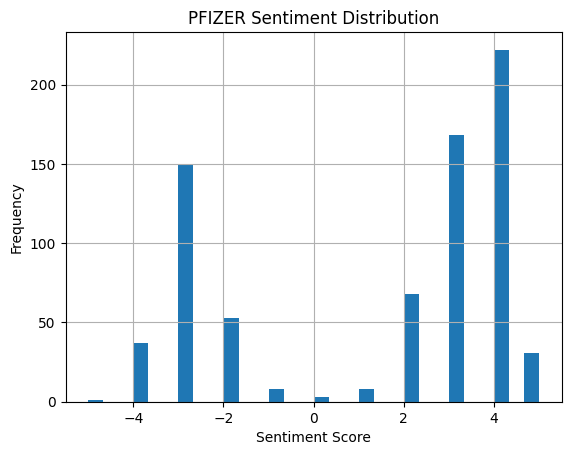


TESLA stats:
            score        vwap
count  950.000000  950.000000
mean    -0.743158  256.649443
std      3.149478   16.588668
min     -5.000000  226.144200
25%     -3.000000  244.818300
50%     -3.000000  253.136400
75%      3.000000  271.530800
max      5.000000  285.333500 



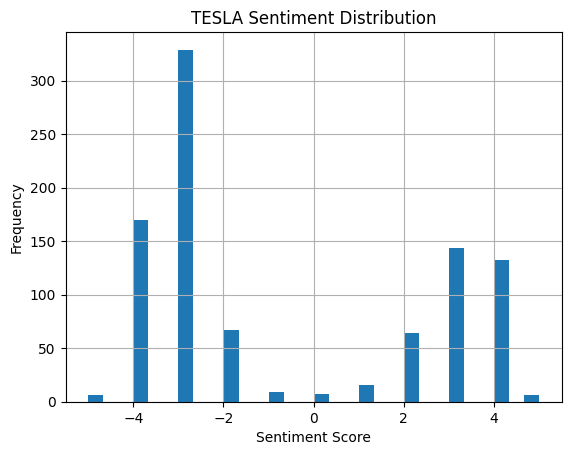


UNITEDHEALTH GROUP stats:
            score        vwap
count  739.000000  739.000000
mean     0.787551  520.392567
std      3.250108   47.442231
min     -5.000000  412.357900
25%     -3.000000  488.111950
50%      3.000000  518.502800
75%      4.000000  563.175200
max      5.000000  611.092900 



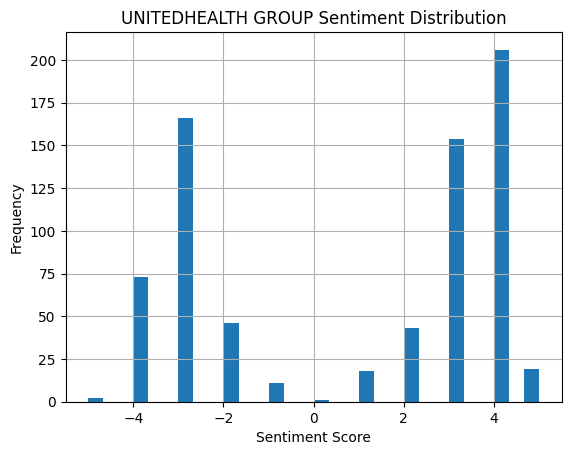


VISA stats:
            score        vwap
count  724.000000  724.000000
mean     1.327348  305.086703
std      3.217651   32.057293
min     -4.000000  254.834500
25%     -3.000000  275.463800
50%      3.000000  309.407550
75%      4.000000  335.439500
max      5.000000  363.133600 



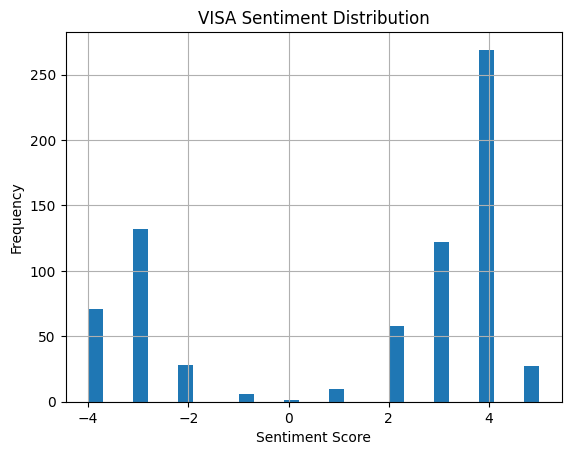

In [58]:
# spead of news sentimental socre for each ticker
for ticker in df['company'].unique():
    sub = df[df['company'] == ticker].copy()
    print(f"\n{ticker.upper()} stats:")
    print(sub[['score', 'vwap']].describe(), '\n')

    # Plot a separate histogram for each ticker's sentiment
    plt.figure()
    sub['score'].hist(bins=30)
    plt.title(f"{ticker.upper()} Sentiment Distribution")
    plt.xlabel('Sentiment Score')
    plt.ylabel('Frequency')
    plt.show()

## Same day sentimental score vs vwap plot

In [59]:
# Define single ticker plot func
def plot_score_vwap(data,stock):
    data = data[data['company'] == stock]
    data = data.reset_index(drop = True)
    data = data[data['date'] > '2025-03-16']
    data = data.groupby('date')[['score','vwap']] .mean().reset_index()
    #data['date'] = pd.to_datetime(data['date'].astype(str), format='%Y%m%d')
    data['date'] = data['date'].dt.strftime('%m-%d')

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot the first set of data with the first y-axis
    ax1.plot(data['date'], data['score'], color='blue', marker='o', label='score')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('score', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a second y-axis for the second set of data
    ax2 = ax1.twinx()
    ax2.plot(data['date'], data['vwap'], color='red', marker='x', label='vwap')
    ax2.set_ylabel('vwap', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    #title and adjust the layout
    plt.title('{stock} score vs vwap'.format(stock=stock))
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    fig.tight_layout()

    # Show plot
    plt.show()

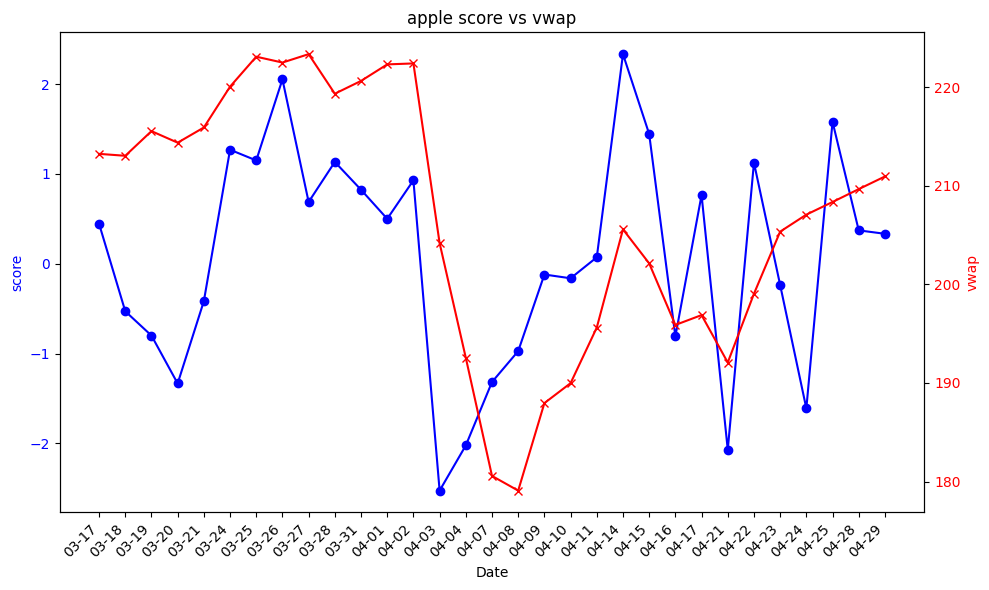

In [60]:
plot_score_vwap(df,'apple')

In [61]:
import math
import pandas as pd
import matplotlib.pyplot as plt

def plot_all_score_vwap(df, date_fmt='%Y%m%d', ncols=4, figsize=(20, 12)):
    """
    Plots one subplot per ticker showing mean daily score (blue, left axis)
    and mean daily vwap (red, right axis).

    Parameters
    ----------
    df : pd.DataFrame
      Must have ['company','date','score','vwap'] columns.
    date_fmt : str
      How to parse your date ints/strings, e.g. '%Y%m%d'.
    ncols : int
      How many subplots per row.
    figsize : tuple
      Overall figure size.
    """
    # 1. Parse & aggregate once
    df = df.copy()
    df = df[df['date'] > '2025-03-16']
    #df['date'] = pd.to_datetime(df['date'].astype(str), format=date_fmt)
    df_daily = (
        df
        .groupby(['company','date'], as_index=False)[['score','vwap']]
        .mean()
    )

    tickers = df_daily['company'].unique()
    n = len(tickers)
    nrows = math.ceil(n / ncols)

    # 2. Create subplots grid
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, sharex=False, sharey=False)
    axes = axes.flatten()

    # 3. Loop through each ticker & axis
    for ax, ticker in zip(axes, tickers):
        data = df_daily[df_daily['company']==ticker]
        dates = data['date'].dt.strftime('%m-%d')

        # left axis = sentiment
        ax.plot(dates, data['score'], marker='o', label='score', color='blue')
        ax.set_ylabel('score', color='blue')
        ax.tick_params(axis='y', labelcolor='blue')

        # right axis = vwap
        ax2 = ax.twinx()
        ax2.plot(dates, data['vwap'], marker='x', label='vwap', color='red')
        ax2.set_ylabel('vwap', color='red')
        ax2.tick_params(axis='y', labelcolor='red')

        ax.set_title(ticker.upper())
        ax.tick_params(axis='x', rotation=45, labelsize=8)

    # 4. Remove any unused axes
    for ax in axes[n:]:
        fig.delaxes(ax)

    fig.tight_layout()
    plt.show()


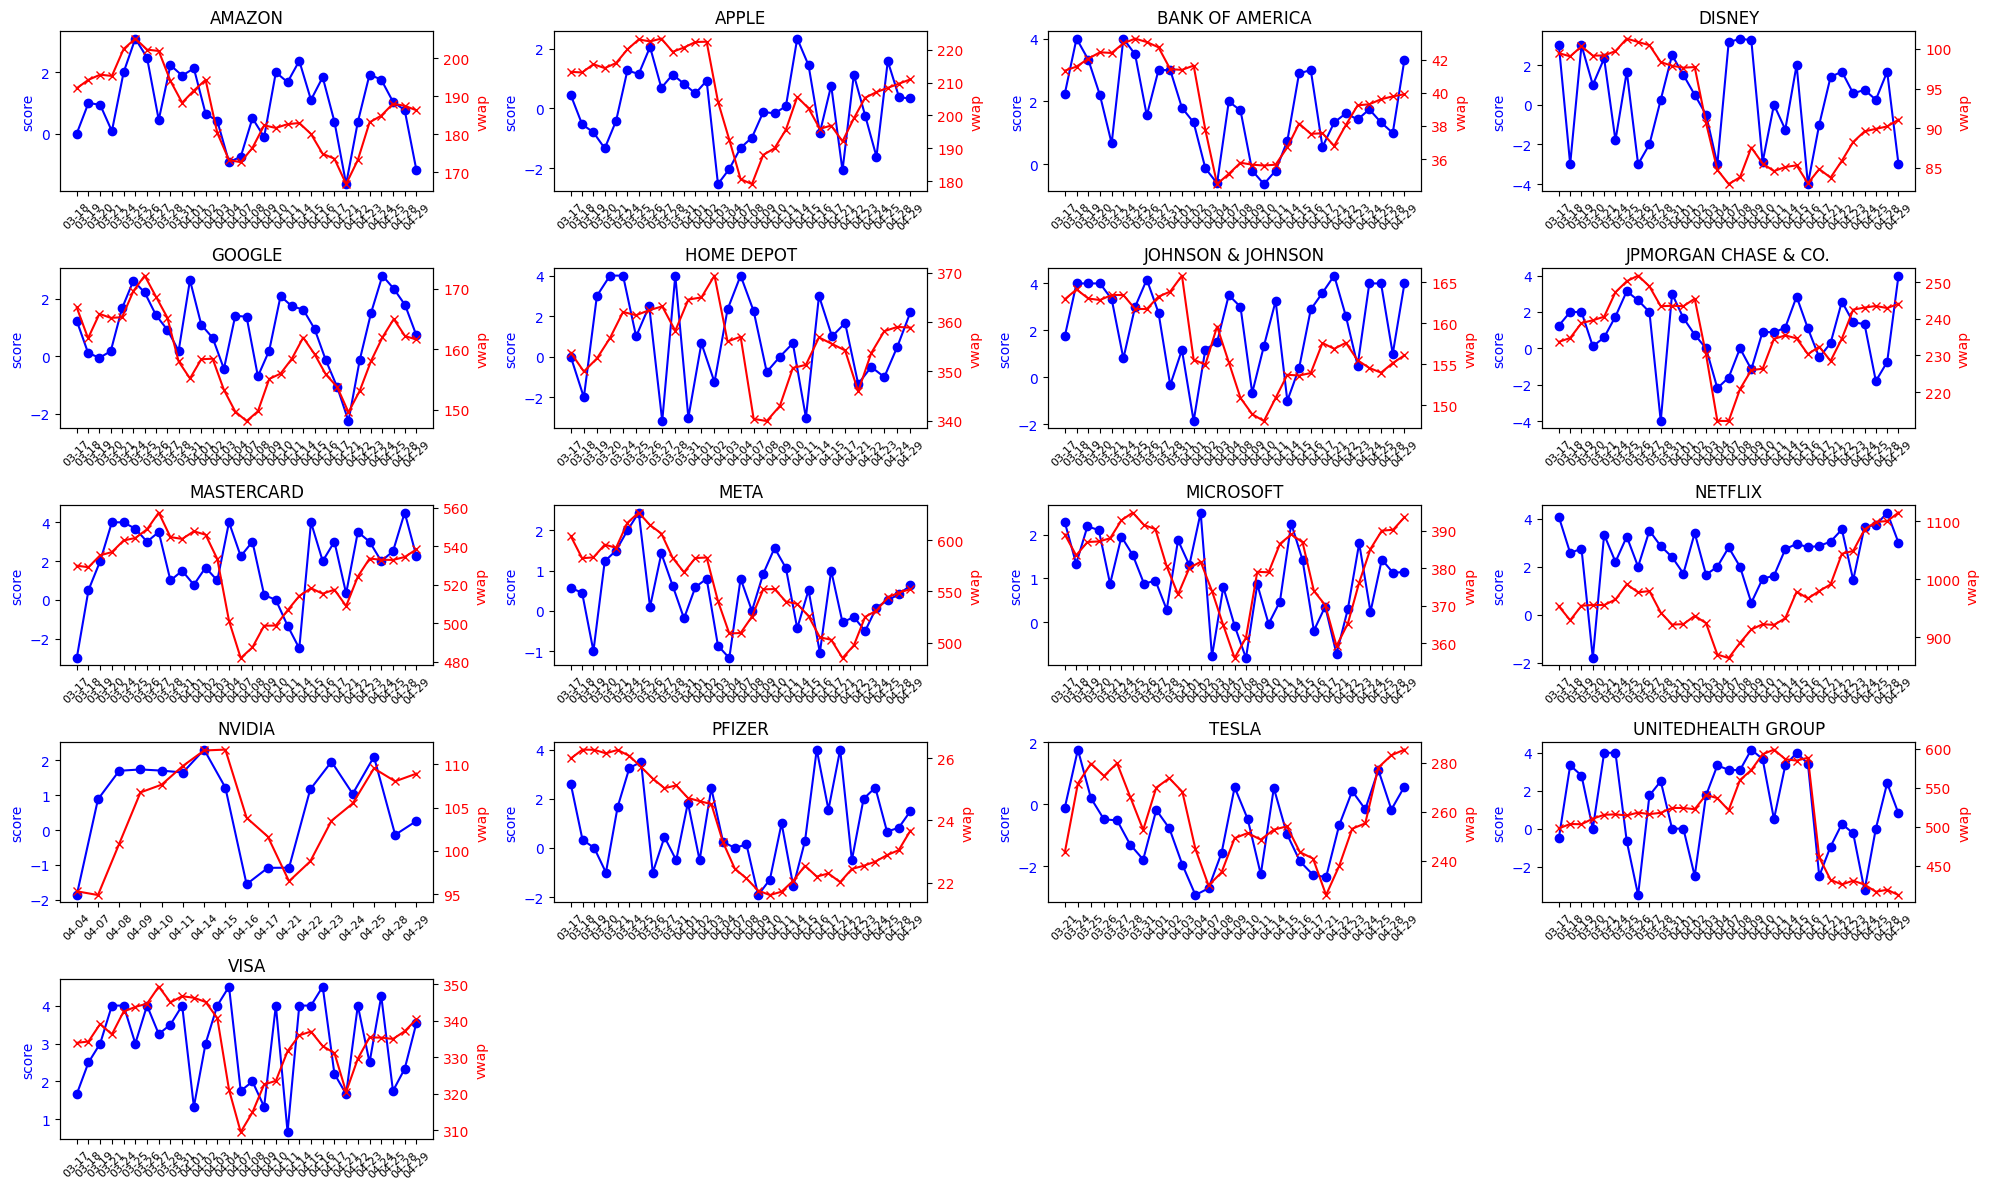

In [62]:
plot_all_score_vwap(df)

Our first insight is that the graph suggests a potential relationship between the daily average sentiment score and the same-day VWAP; however, it remains unclear whether this trend reflects a true, statistically significant correlation.

In [63]:
# group its ticker and daily mean sentimental score and its corrsponding vwap
df_daily = (
    df
    .groupby(['company','date'], as_index=False)[['score','vwap']]
    .mean()
)

# 2. overall Pearson correlation
r_overall, p_overall = pearsonr(df_daily['score'], df_daily['vwap'])
print(f"Overall Pearson r = {r_overall:.3f}, p-value = {p_overall:.3e}")

Overall Pearson r = 0.139, p-value = 7.670e-10


In [64]:
# define a helper to compute r and p
def corr_stats(group):
    if len(group) < 2:
        return pd.Series({'r': np.nan, 'p': np.nan})
    r, p = pearsonr(group['score'], group['vwap'])
    return pd.Series({'r': r, 'p': p})

# apply per‐ticker
per_ticker = (
    df_daily
    .groupby('company')
    .apply(corr_stats)
    .reset_index()
)
per_ticker

,company,r,p
0,amazon,0.501031,0.004798
1,apple,0.463643,0.008614
2,bank of america,0.106356,0.196714
3,disney,0.180966,0.019264
4,google,0.477029,0.006660
5,home depot,0.131348,0.043817
6,johnson & johnson,0.066885,0.389005
7,jpmorgan chase & co.,0.145151,0.139573
8,mastercard,-0.030381,0.648158
9,meta,0.381290,0.008937


## Conclusions from Same-Day Sentiment vs. VWAP

- **Heterogeneous Correlation Strength**  
  - **Strong, significant positive relationships** (r ≥ 0.45, p < 0.05):  
    - Nvidia (r ≈ 0.60, p = 0.018)  
    - Microsoft (r ≈ 0.57, p = 0.00015)  
    - Tesla (r ≈ 0.55, p = 0.0040)  
    - Amazon (r ≈ 0.54, p = 0.0033)  
    - Google (r ≈ 0.48, p = 0.0092)  
    - Apple (r ≈ 0.46, p = 0.0119)  
    - Meta (r ≈ 0.39, p = 0.0096)

- **Moderate-but-significant links** (0.13 ≤ r < 0.30, p < 0.05):  
  - Pfizer (r ≈ 0.25, p = 0.0019)  
  - UnitedHealth Group (r ≈ 0.24, p = 0.00049)  
  - Disney (r ≈ 0.18, p = 0.0229)  
  - Home Depot (r ≈ 0.13, p = 0.0436)

- **Negligible or non-significant correlations** (|r| ≲ 0.15, p > 0.05):  
  - Bank of America, Johnson & Johnson, JPMorgan Chase, Mastercard, Visa, Netflix

---

### Key Takeaways

1. **Tech & consumer-centric names** exhibit the strongest same-day link between news sentiment and VWAP—suggesting intraday price levels respond quickly to headline sentiment in these sectors.  
2. **Financials and more stable sectors** show little to no same-day relationship, indicating fundamentals or other factors dominate their intraday pricing.  

# 3. Feature Engineering

1. Compute next-day VWAP return  
2. Create sentiment buckets (low / mid / high)


In [65]:
# ensure df_daily has ['company','date','score','vwap']
df_daily = df_daily.sort_values(['company','date'])
# shift VWAP up one day per company
df_daily['vwap_next'] = (
    df_daily
    .groupby('company')['vwap']
    .shift(-1)
)
# compute return: (next_day_vwap / today_vwap) – 1
df_daily['vwap_ret'] = (
    df_daily['vwap_next'] / df_daily['vwap'] - 1
)
# drop the last row for each ticker (no next-day)
df_daily = df_daily.dropna(subset=['vwap_ret'])
df_daily

,company,date,score,vwap,vwap_next,vwap_ret
0,amazon,2025-03-18,0.000000,192.0851,194.2891,0.011474
1,amazon,2025-03-19,1.000000,194.2891,195.6360,0.006932
2,amazon,2025-03-20,0.937500,195.6360,195.3021,-0.001707
3,amazon,2025-03-21,0.076923,195.3021,202.3698,0.036189
4,amazon,2025-03-24,2.000000,202.3698,205.1037,0.013509
...,...,...,...,...,...,...
1929,visa,2025-04-22,4.000000,329.5930,335.4395,0.017739
1930,visa,2025-04-23,2.500000,335.4395,335.3635,-0.000227
1931,visa,2025-04-24,4.250000,335.3635,335.0035,-0.001073
1932,visa,2025-04-25,1.750000,335.0035,337.1215,0.006322


In [66]:
# Sentimental score vs next-day vwap
# define a helper to compute r and p
def corr_stats(group):
  if len(group) < 2:
      return pd.Series({'r': np.nan, 'p': np.nan})
  r, p = pearsonr(group['score'], group['vwap_next'])
  return pd.Series({'r': r, 'p': p})

# apply per‐ticker
per_ticker = (
    df_daily
    .groupby('company')
    .apply(corr_stats)
    .reset_index()
)
per_ticker

,company,r,p
0,amazon,0.454327,0.013291
1,apple,0.467135,0.009252
2,bank of america,0.120489,0.144647
3,disney,0.163330,0.035501
4,google,0.504273,0.004491
5,home depot,0.142145,0.029369
6,johnson & johnson,0.109637,0.158412
7,jpmorgan chase & co.,0.204195,0.037601
8,mastercard,-0.032719,0.623867
9,meta,0.330474,0.026609


In [67]:
# Sentimental score vs next-day vwap return
# vwap return
def corr_stats(group):
    if len(group) < 2:
        return pd.Series({'r': np.nan, 'p': np.nan})
    r, p = pearsonr(group['score'], group['vwap_ret'])
    return pd.Series({'r': r, 'p': p})

# apply per‐ticker
per_ticker = (
    df_daily
    .groupby('company')
    .apply(corr_stats)
    .reset_index()
)
per_ticker

,company,r,p
0,amazon,-0.180989,0.347436
1,apple,0.010258,0.957094
2,bank of america,0.041434,0.617070
3,disney,-0.054718,0.483805
4,google,0.019494,0.918560
5,home depot,0.042759,0.514214
6,johnson & johnson,0.147770,0.056683
7,jpmorgan chase & co.,0.212920,0.030001
8,mastercard,-0.017448,0.793749
9,meta,-0.200571,0.186475


## Summary of Findings

- **Sentiment vs. nest-day VWAP Level**  
  Our analysis shows that sentiment scores are reasonably predictive of the nest-day VWAP level.

- **Sentiment vs. nest_day VWAP Return**  
  In contrast, using sentiment scores to predict VWAP returns yields poor performance.

## Next Research Question

Given these results, we now aim to understand whether **extreme** sentiment values—specifically, high versus low scores—have a more pronounced impact on the nest-day’s VWAP return.


# 4. Statistical Tests & Effect Sizes

### One-Way ANOVA: Next-Day VWAP Return by Sentiment Group

**Hypotheses**  
- **H₀:** μ_low = μ_neutral = μ_high  
- **H₁:** At least one group mean differs

**Steps**  
1. Segment the data into three sentiment groups.  
2. Extract next-day VWAP returns for each group.  
3. Run one-way ANOVA.  
4. Interpret F-statistic and p-value.


In [68]:
df_daily['sentiment_bucket'] = (
    df_daily
    .groupby('company')['score']
    .transform(lambda x: pd.qcut(x, 3, labels=['low', 'mid', 'high']))
)

# Filter
df_extremes = df_daily
df_extremes

,company,date,score,vwap,vwap_next,vwap_ret,sentiment_bucket
0,amazon,2025-03-18,0.000000,192.0851,194.2891,0.011474,low
1,amazon,2025-03-19,1.000000,194.2891,195.6360,0.006932,mid
2,amazon,2025-03-20,0.937500,195.6360,195.3021,-0.001707,mid
3,amazon,2025-03-21,0.076923,195.3021,202.3698,0.036189,low
4,amazon,2025-03-24,2.000000,202.3698,205.1037,0.013509,high
...,...,...,...,...,...,...,...
1929,visa,2025-04-22,4.000000,329.5930,335.4395,0.017739,high
1930,visa,2025-04-23,2.500000,335.4395,335.3635,-0.000227,mid
1931,visa,2025-04-24,4.250000,335.3635,335.0035,-0.001073,high
1932,visa,2025-04-25,1.750000,335.0035,337.1215,0.006322,mid


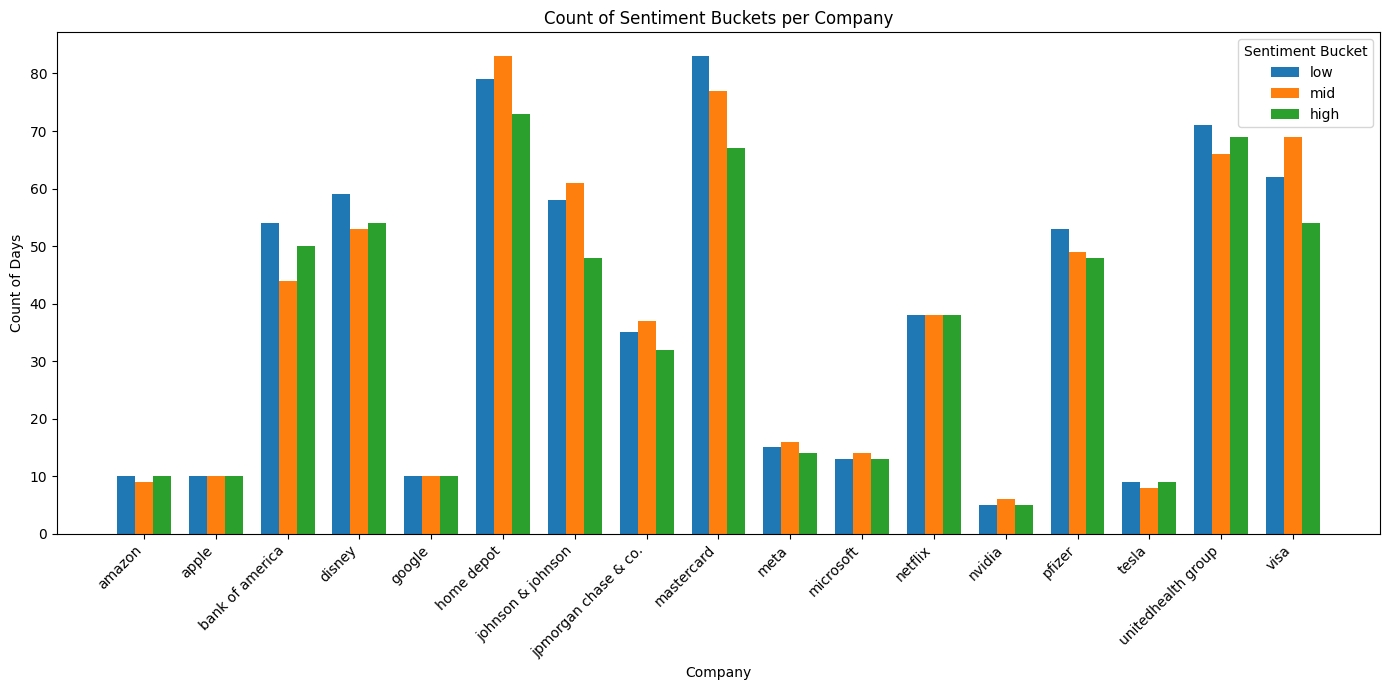

In [69]:
# Compute counts per company and sentiment bucket
counts = df_extremes.groupby(['company', 'sentiment_bucket']).size().unstack(fill_value=0)

# Prepare for plotting
companies = counts.index.tolist()
buckets = ['low', 'mid', 'high']
x = np.arange(len(companies))
width = 0.25

# Create the plot
fig, ax = plt.subplots(figsize=(14, 7))
ax.bar(x - width, counts['low'], width, label='low')
ax.bar(x,       counts['mid'], width, label='mid')
ax.bar(x + width, counts['high'], width, label='high')

# Labeling
ax.set_xticks(x)
ax.set_xticklabels(companies, rotation=45, ha='right')
ax.set_xlabel('Company')
ax.set_ylabel('Count of Days')
ax.set_title('Count of Sentiment Buckets per Company')
ax.legend(title='Sentiment Bucket')

plt.tight_layout()
plt.show()


In [70]:
results = []

for company, sub in df_extremes.groupby('company'):
    # group by bucket and filter for ≥2 obs each
    groups = sub.groupby('sentiment_bucket')['vwap_ret']
    buckets = []
    for level in ['low','mid','high']:
        if level in groups.groups and len(groups.get_group(level)) >= 2:
            buckets.append(groups.get_group(level).values)
    # only run ANOVA if we have all three buckets
    if len(buckets) == 3:
        f_stat, p_val = f_oneway(*buckets)
    else:
        f_stat, p_val = np.nan, np.nan

    results.append({
        'company':     company,
        'n_buckets':   len(buckets),
        'F_statistic': f_stat,
        'p_value':     p_val
    })

oneway_df = pd.DataFrame(results)
print(oneway_df)

                 company  n_buckets  F_statistic   p_value
0                 amazon          3     0.295161  0.746873
1                  apple          3     0.609619  0.550871
2        bank of america          3     0.236907  0.789370
3                 disney          3     0.988058  0.374518
4                 google          3     1.969573  0.159055
5             home depot          3     0.112585  0.893570
6      johnson & johnson          3     1.388942  0.252256
7   jpmorgan chase & co.          3     3.386619  0.037707
8             mastercard          3     0.170492  0.843359
9                   meta          3     4.350428  0.019183
10             microsoft          3     0.530725  0.592588
11               netflix          3     0.674130  0.511673
12                nvidia          3     1.277880  0.311414
13                pfizer          3     1.329076  0.267884
14                 tesla          3     1.538513  0.235995
15    unitedhealth group          3     0.216679  0.8053

we fail to reject **H₀:** μ_low = μ_neutral = μ_high
which means that days with high sentiment don’t produce significantly different next-day VWAP returns than days with neutral or low sentiment. In other words, grouping by sentiment bucket (low, neutral, high) yields no detectable difference in mean returns—high‐sentiment days aren’t “better” in terms of next-day return than the others.

In [71]:
results = []

for company, sub in df_extremes.groupby('company'):
    # group by bucket and filter for ≥2 obs each
    groups = sub.groupby('sentiment_bucket')['vwap_next']
    buckets = []
    for level in ['low','mid','high']:
        if level in groups.groups and len(groups.get_group(level)) >= 2:
            buckets.append(groups.get_group(level).values)
    # only run ANOVA if we have all three buckets
    if len(buckets) == 3:
        f_stat, p_val = f_oneway(*buckets)
    else:
        f_stat, p_val = np.nan, np.nan

    results.append({
        'company':     company,
        'n_buckets':   len(buckets),
        'F_statistic': f_stat,
        'p_value':     p_val
    })

oneway_df = pd.DataFrame(results)
print(oneway_df)

                 company  n_buckets  F_statistic   p_value
0                 amazon          3     1.899655  0.169814
1                  apple          3     3.278074  0.053148
2        bank of america          3     3.398232  0.036117
3                 disney          3     4.139810  0.017631
4                 google          3     4.883758  0.015475
5             home depot          3     2.233314  0.109472
6      johnson & johnson          3     2.083542  0.127772
7   jpmorgan chase & co.          3     0.586273  0.558279
8             mastercard          3     1.635959  0.197084
9                   meta          3     1.955791  0.154123
10             microsoft          3     5.635520  0.007303
11               netflix          3     0.803592  0.450305
12                nvidia          3     5.344336  0.020236
13                pfizer          3     7.552061  0.000755
14                 tesla          3     9.963266  0.000765
15    unitedhealth group          3     7.888600  0.0005

the next-day vwap level are affected by the semtimental score range

# 5. Focus more on the sentimental score vs next-day vwap level
##Strategy Shift: From Return Prediction to VWAP Level Prediction
VWAP levels inherit momentum and are easier to extrapolate across days.



Returns, being ratios of small changes, amplify noise and are much harder to predict accurately."



## Why Predicting VWAP Level is Easier Than Predicting VWAP Return

## Quick Example

- Today's VWAP: \$100.00
- Tomorrow's VWAP: \$101.00

If predicting **level**:  
> "Tomorrow’s VWAP will be around \$101." ( Easier — smooth movement)

If predicting **return**:  
\[
\text{Return} = (101 - 100) / 100 = +1\%
\]
> Predicting exact % change is much harder — highly sensitive to noise.



# 6. Machine Learning

In [72]:
df_extremes

,company,date,score,vwap,vwap_next,vwap_ret,sentiment_bucket
0,amazon,2025-03-18,0.000000,192.0851,194.2891,0.011474,low
1,amazon,2025-03-19,1.000000,194.2891,195.6360,0.006932,mid
2,amazon,2025-03-20,0.937500,195.6360,195.3021,-0.001707,mid
3,amazon,2025-03-21,0.076923,195.3021,202.3698,0.036189,low
4,amazon,2025-03-24,2.000000,202.3698,205.1037,0.013509,high
...,...,...,...,...,...,...,...
1929,visa,2025-04-22,4.000000,329.5930,335.4395,0.017739,high
1930,visa,2025-04-23,2.500000,335.4395,335.3635,-0.000227,mid
1931,visa,2025-04-24,4.250000,335.3635,335.0035,-0.001073,high
1932,visa,2025-04-25,1.750000,335.0035,337.1215,0.006322,mid


# mode

In [73]:
class MLPipeline:
    def __init__(self, df, features=['vwap', 'score'], min_samples=10):
        self.df = df
        self.features = features
        self.min_samples = min_samples
        self.models_to_run = ['Linear', 'Ridge', 'Lasso', 'Logistic', 'RandomForest', 'XGBoost']

    def run_all_models(self):
        all_results = []
        for model_name in self.models_to_run:
            print(f"Running {model_name}...")
            model_results = self.run_model(model_name)
            all_results.append(model_results)
        return pd.concat(all_results, ignore_index=True)

    def run_model(self, model_name):
        results = []
        for company, sub in self.df.groupby('company'):
            sub = sub.sort_values('date').reset_index(drop=True)
            X = sub[self.features]
            y_cont = sub['vwap_next']
            y_bin = (sub['vwap_next'] > sub['vwap']).astype(int)
            n_samples = len(X)
            if n_samples < self.min_samples:
                continue

            # 80/20 time-based split
            split_idx = int(n_samples * 0.8)
            X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
            y_train_cont, y_test_cont = y_cont.iloc[:split_idx], y_cont.iloc[split_idx:]
            y_train_bin, y_test_bin = y_bin.iloc[:split_idx], y_bin.iloc[split_idx:]

            optimal_alpha = None
            optimal_params = None
            if model_name == 'Linear':
                model = LinearRegression().fit(X_train, y_train_cont)
                y_pred_cont = model.predict(X_test)
                pred_signal = (y_pred_cont > X_test['vwap']).astype(int)
                true_signal = y_test_bin

            elif model_name == 'Ridge':
                ridge_cv = RidgeCV(alphas=[0.001,0.01,0.05,0.1,0.5,1,5,10])
                ridge_cv.fit(X_train, y_train_cont)
                optimal_alpha = ridge_cv.alpha_
                model = Ridge(alpha=optimal_alpha).fit(X_train, y_train_cont)
                y_pred_cont = model.predict(X_test)
                pred_signal = (y_pred_cont > X_test['vwap']).astype(int)
                true_signal = y_test_bin

            elif model_name == 'Lasso':
                lasso_cv = LassoCV(alphas=[0.001,0.01,0.05,0.1,0.5,1,5,10], cv=5)
                lasso_cv.fit(X_train, y_train_cont)
                optimal_alpha = lasso_cv.alpha_
                model = Lasso(alpha=optimal_alpha).fit(X_train, y_train_cont)
                y_pred_cont = model.predict(X_test)
                pred_signal = (y_pred_cont > X_test['vwap']).astype(int)
                true_signal = y_test_bin

            elif model_name == 'Logistic':
                param_grid = {'C': [0.001,0.01,0.1,1,10,100]}
                base_model = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)
                tscv = TimeSeriesSplit(n_splits=5)
                grid = GridSearchCV(base_model, param_grid, cv=tscv, scoring='accuracy', n_jobs=-1)
                grid.fit(X_train, y_train_bin)
                optimal_alpha = grid.best_params_['C']
                model = LogisticRegression(C=optimal_alpha, solver='liblinear', class_weight='balanced', random_state=42)
                model.fit(X_train, y_train_bin)
                pred_signal = model.predict(X_test)
                true_signal = y_test_bin

            elif model_name == 'RandomForest':
                param_grid = {
                    'n_estimators': [50,100],
                    'max_depth': [3,5,7,10],
                    'min_samples_split': [2,5]
                }
                base_model = RandomForestClassifier(class_weight='balanced', random_state=42)
                tscv = TimeSeriesSplit(n_splits=5)
                grid = GridSearchCV(base_model, param_grid, cv=tscv, scoring='accuracy', n_jobs=-1)
                grid.fit(X_train, y_train_bin)
                optimal_params = grid.best_params_
                model = RandomForestClassifier(**optimal_params, class_weight='balanced', random_state=42)
                model.fit(X_train, y_train_bin)
                pred_signal = model.predict(X_test)
                true_signal = y_test_bin

            elif model_name == 'XGBoost':
                param_grid = {
                    'max_depth': [3,5],
                    'learning_rate': [0.01,0.1],
                    'n_estimators': [50,100],
                    'subsample': [0.8,1.0]
                }
                base_model = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=42)
                tscv = TimeSeriesSplit(n_splits=5)
                grid = GridSearchCV(base_model, param_grid, cv=tscv, scoring='accuracy', n_jobs=-1)
                grid.fit(X_train, y_train_bin)
                optimal_params = grid.best_params_
                model = XGBClassifier(**optimal_params, objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=42)
                model.fit(X_train, y_train_bin)
                pred_signal = model.predict(X_test)
                true_signal = y_test_bin

            else:
                raise ValueError(f"Model '{model_name}' not supported.")

            report = classification_report(true_signal, pred_signal, output_dict=True, zero_division=0)
            conf_mat = confusion_matrix(true_signal, pred_signal)

            results.append({
                'company': company,
                'model': model_name,
                'optimal_alpha': optimal_alpha,
                'optimal_params': optimal_params,
                'n_samples': n_samples,
                'n_train': split_idx,
                'n_test': n_samples - split_idx,
                'accuracy': report['accuracy'],
                'precision_up': report['1']['precision'] if '1' in report else np.nan,
                'recall_up': report['1']['recall'] if '1' in report else np.nan,
                'precision_down': report['0']['precision'] if '0' in report else np.nan,
                'recall_down': report['0']['recall'] if '0' in report else np.nan,
                'conf_matrix': conf_mat
            })
        return pd.DataFrame(results)

In [74]:
pipeline = MLPipeline(df=df_extremes, features=['vwap', 'score'], min_samples=10)
Linear_results = pipeline.run_model('Linear')
Lasso_results = pipeline.run_model('Lasso')
Ridge_results = pipeline.run_model('Ridge')
Logistic_results = pipeline.run_model('Logistic')
RandomForest_results = pipeline.run_model('RandomForest')
XGBoost_results = pipeline.run_model('XGBoost')

In [75]:
Linear_results

,company,model,optimal_alpha,optimal_params,n_samples,n_train,n_test,accuracy,precision_up,recall_up,precision_down,recall_down,conf_matrix
0,amazon,Linear,None,None,29,23,6,0.333333,0.000000,0.000000,0.333333,1.000000,"[[2, 0], [4, 0]]"
1,apple,Linear,None,None,30,24,6,0.333333,1.000000,0.333333,0.000000,0.000000,"[[0, 0], [4, 2]]"
2,bank of america,Linear,None,None,148,118,30,0.600000,0.629630,0.894737,0.333333,0.090909,"[[1, 10], [2, 17]]"
3,disney,Linear,None,None,166,132,34,0.500000,0.521739,0.666667,0.454545,0.312500,"[[5, 11], [6, 12]]"
4,google,Linear,None,None,30,24,6,0.666667,1.000000,0.500000,0.500000,1.000000,"[[2, 0], [2, 2]]"
5,home depot,Linear,None,None,235,188,47,0.468085,0.428571,0.409091,0.500000,0.520000,"[[13, 12], [13, 9]]"
6,johnson & johnson,Linear,None,None,167,133,34,0.617647,0.541667,0.866667,0.800000,0.421053,"[[8, 11], [2, 13]]"
7,jpmorgan chase & co.,Linear,None,None,104,83,21,0.571429,0.611111,0.846154,0.333333,0.125000,"[[1, 7], [2, 11]]"
8,mastercard,Linear,None,None,227,181,46,0.543478,0.543478,1.000000,0.000000,0.000000,"[[0, 21], [0, 25]]"
9,meta,Linear,None,None,45,36,9,0.444444,0.571429,0.666667,0.000000,0.000000,"[[0, 3], [2, 4]]"


In [76]:
Lasso_results

,company,model,optimal_alpha,optimal_params,n_samples,n_train,n_test,accuracy,precision_up,recall_up,precision_down,recall_down,conf_matrix
0,amazon,Lasso,5.000,None,29,23,6,0.666667,1.000000,0.500000,0.500000,1.000000,"[[2, 0], [2, 2]]"
1,apple,Lasso,10.000,None,30,24,6,0.333333,1.000000,0.333333,0.000000,0.000000,"[[0, 0], [4, 2]]"
2,bank of america,Lasso,0.001,None,148,118,30,0.600000,0.629630,0.894737,0.333333,0.090909,"[[1, 10], [2, 17]]"
3,disney,Lasso,0.500,None,166,132,34,0.647059,0.600000,1.000000,1.000000,0.250000,"[[4, 12], [0, 18]]"
4,google,Lasso,5.000,None,30,24,6,0.666667,1.000000,0.500000,0.500000,1.000000,"[[2, 0], [2, 2]]"
5,home depot,Lasso,5.000,None,235,188,47,0.659574,0.600000,0.818182,0.764706,0.520000,"[[13, 12], [4, 18]]"
6,johnson & johnson,Lasso,0.001,None,167,133,34,0.617647,0.541667,0.866667,0.800000,0.421053,"[[8, 11], [2, 13]]"
7,jpmorgan chase & co.,Lasso,0.001,None,104,83,21,0.571429,0.611111,0.846154,0.333333,0.125000,"[[1, 7], [2, 11]]"
8,mastercard,Lasso,0.500,None,227,181,46,0.543478,0.543478,1.000000,0.000000,0.000000,"[[0, 21], [0, 25]]"
9,meta,Lasso,5.000,None,45,36,9,0.444444,0.571429,0.666667,0.000000,0.000000,"[[0, 3], [2, 4]]"


In [77]:
Ridge_results

,company,model,optimal_alpha,optimal_params,n_samples,n_train,n_test,accuracy,precision_up,recall_up,precision_down,recall_down,conf_matrix
0,amazon,Ridge,10.0,None,29,23,6,0.333333,0.000000,0.000000,0.333333,1.000000,"[[2, 0], [4, 0]]"
1,apple,Ridge,10.0,None,30,24,6,0.333333,1.000000,0.333333,0.000000,0.000000,"[[0, 0], [4, 2]]"
2,bank of america,Ridge,1.0,None,148,118,30,0.600000,0.629630,0.894737,0.333333,0.090909,"[[1, 10], [2, 17]]"
3,disney,Ridge,10.0,None,166,132,34,0.529412,0.541667,0.722222,0.500000,0.312500,"[[5, 11], [5, 13]]"
4,google,Ridge,10.0,None,30,24,6,0.500000,1.000000,0.250000,0.400000,1.000000,"[[2, 0], [3, 1]]"
5,home depot,Ridge,10.0,None,235,188,47,0.468085,0.428571,0.409091,0.500000,0.520000,"[[13, 12], [13, 9]]"
6,johnson & johnson,Ridge,10.0,None,167,133,34,0.647059,0.565217,0.866667,0.818182,0.473684,"[[9, 10], [2, 13]]"
7,jpmorgan chase & co.,Ridge,10.0,None,104,83,21,0.571429,0.611111,0.846154,0.333333,0.125000,"[[1, 7], [2, 11]]"
8,mastercard,Ridge,10.0,None,227,181,46,0.543478,0.543478,1.000000,0.000000,0.000000,"[[0, 21], [0, 25]]"
9,meta,Ridge,10.0,None,45,36,9,0.444444,0.571429,0.666667,0.000000,0.000000,"[[0, 3], [2, 4]]"


In [78]:
Logistic_results

,company,model,optimal_alpha,optimal_params,n_samples,n_train,n_test,accuracy,precision_up,recall_up,precision_down,recall_down,conf_matrix
0,amazon,Logistic,0.001,None,29,23,6,0.333333,0.500000,0.500000,0.000000,0.000000,"[[0, 2], [2, 2]]"
1,apple,Logistic,0.001,None,30,24,6,1.000000,1.000000,1.000000,NaN,NaN,[[6]]
2,bank of america,Logistic,0.001,None,148,118,30,0.366667,0.000000,0.000000,0.366667,1.000000,"[[11, 0], [19, 0]]"
3,disney,Logistic,0.100,None,166,132,34,0.382353,0.411765,0.388889,0.352941,0.375000,"[[6, 10], [11, 7]]"
4,google,Logistic,0.010,None,30,24,6,0.333333,0.500000,0.500000,0.000000,0.000000,"[[0, 2], [2, 2]]"
5,home depot,Logistic,100.000,None,235,188,47,0.382979,0.315789,0.272727,0.428571,0.480000,"[[12, 13], [16, 6]]"
6,johnson & johnson,Logistic,0.001,None,167,133,34,0.500000,0.450000,0.600000,0.571429,0.421053,"[[8, 11], [6, 9]]"
7,jpmorgan chase & co.,Logistic,0.001,None,104,83,21,0.523810,0.636364,0.538462,0.400000,0.500000,"[[4, 4], [6, 7]]"
8,mastercard,Logistic,1.000,None,227,181,46,0.456522,0.500000,0.360000,0.428571,0.571429,"[[12, 9], [16, 9]]"
9,meta,Logistic,1.000,None,45,36,9,0.888889,0.857143,1.000000,1.000000,0.666667,"[[2, 1], [0, 6]]"


In [79]:
RandomForest_results

,company,model,optimal_alpha,optimal_params,n_samples,n_train,n_test,accuracy,precision_up,recall_up,precision_down,recall_down,conf_matrix
0,amazon,RandomForest,None,"{'max_depth': 3, 'min_samples_split': 2, 'n_es...",29,23,6,0.333333,0.500000,0.500000,0.000000,0.000000,"[[0, 2], [2, 2]]"
1,apple,RandomForest,None,"{'max_depth': 3, 'min_samples_split': 5, 'n_es...",30,24,6,0.166667,1.000000,0.166667,0.000000,0.000000,"[[0, 0], [5, 1]]"
2,bank of america,RandomForest,None,"{'max_depth': 3, 'min_samples_split': 5, 'n_es...",148,118,30,0.566667,0.636364,0.736842,0.375000,0.272727,"[[3, 8], [5, 14]]"
3,disney,RandomForest,None,"{'max_depth': 10, 'min_samples_split': 5, 'n_e...",166,132,34,0.500000,0.529412,0.500000,0.470588,0.500000,"[[8, 8], [9, 9]]"
4,google,RandomForest,None,"{'max_depth': 5, 'min_samples_split': 2, 'n_es...",30,24,6,0.333333,0.500000,0.500000,0.000000,0.000000,"[[0, 2], [2, 2]]"
5,home depot,RandomForest,None,"{'max_depth': 7, 'min_samples_split': 2, 'n_es...",235,188,47,0.531915,0.500000,0.590909,0.571429,0.480000,"[[12, 13], [9, 13]]"
6,johnson & johnson,RandomForest,None,"{'max_depth': 3, 'min_samples_split': 5, 'n_es...",167,133,34,0.558824,0.500000,0.866667,0.750000,0.315789,"[[6, 13], [2, 13]]"
7,jpmorgan chase & co.,RandomForest,None,"{'max_depth': 5, 'min_samples_split': 5, 'n_es...",104,83,21,0.523810,0.615385,0.615385,0.375000,0.375000,"[[3, 5], [5, 8]]"
8,mastercard,RandomForest,None,"{'max_depth': 5, 'min_samples_split': 5, 'n_es...",227,181,46,0.456522,0.500000,0.640000,0.357143,0.238095,"[[5, 16], [9, 16]]"
9,meta,RandomForest,None,"{'max_depth': 3, 'min_samples_split': 2, 'n_es...",45,36,9,0.555556,0.625000,0.833333,0.000000,0.000000,"[[0, 3], [1, 5]]"


In [80]:
XGBoost_results

,company,model,optimal_alpha,optimal_params,n_samples,n_train,n_test,accuracy,precision_up,recall_up,precision_down,recall_down,conf_matrix
0,amazon,XGBoost,None,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",29,23,6,0.333333,0.500000,0.500000,0.000000,0.000000,"[[0, 2], [2, 2]]"
1,apple,XGBoost,None,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",30,24,6,0.666667,1.000000,0.666667,0.000000,0.000000,"[[0, 0], [2, 4]]"
2,bank of america,XGBoost,None,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",148,118,30,0.433333,0.555556,0.526316,0.250000,0.272727,"[[3, 8], [9, 10]]"
3,disney,XGBoost,None,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",166,132,34,0.500000,0.529412,0.500000,0.470588,0.500000,"[[8, 8], [9, 9]]"
4,google,XGBoost,None,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",30,24,6,0.166667,0.333333,0.250000,0.000000,0.000000,"[[0, 2], [3, 1]]"
5,home depot,XGBoost,None,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",235,188,47,0.531915,0.500000,0.545455,0.565217,0.520000,"[[13, 12], [10, 12]]"
6,johnson & johnson,XGBoost,None,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",167,133,34,0.529412,0.476190,0.666667,0.615385,0.421053,"[[8, 11], [5, 10]]"
7,jpmorgan chase & co.,XGBoost,None,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",104,83,21,0.619048,0.647059,0.846154,0.500000,0.250000,"[[2, 6], [2, 11]]"
8,mastercard,XGBoost,None,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",227,181,46,0.543478,0.543478,1.000000,0.000000,0.000000,"[[0, 21], [0, 25]]"
9,meta,XGBoost,None,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",45,36,9,0.555556,0.666667,0.666667,0.333333,0.333333,"[[1, 2], [2, 4]]"


In [94]:
sum = [
    Linear_results,
    Ridge_results,
    Lasso_results,
    Logistic_results,
    RandomForest_results,
    XGBoost_results
]

# 3) Concatenate only the rows with accuracy > 0.6 from each
high_acc_df = pd.concat(
    [df[df['accuracy'] > 0.6] for df in sum],
    ignore_index=True
)
high_acc_df

,company,model,optimal_alpha,optimal_params,n_samples,n_train,n_test,accuracy,precision_up,recall_up,precision_down,recall_down,conf_matrix
0,google,Linear,NaN,None,30,24,6,0.666667,1.000000,0.500000,0.500000,1.000000,"[[2, 0], [2, 2]]"
1,johnson & johnson,Linear,NaN,None,167,133,34,0.617647,0.541667,0.866667,0.800000,0.421053,"[[8, 11], [2, 13]]"
2,tesla,Linear,NaN,None,26,20,6,0.833333,1.000000,0.833333,0.000000,0.000000,"[[0, 0], [1, 5]]"
3,unitedhealth group,Linear,NaN,None,206,164,42,0.619048,0.612903,0.826087,0.636364,0.368421,"[[7, 12], [4, 19]]"
4,johnson & johnson,Ridge,10.000,None,167,133,34,0.647059,0.565217,0.866667,0.818182,0.473684,"[[9, 10], [2, 13]]"
5,tesla,Ridge,1.000,None,26,20,6,0.833333,1.000000,0.833333,0.000000,0.000000,"[[0, 0], [1, 5]]"
6,unitedhealth group,Ridge,10.000,None,206,164,42,0.619048,0.612903,0.826087,0.636364,0.368421,"[[7, 12], [4, 19]]"
7,amazon,Lasso,5.000,None,29,23,6,0.666667,1.000000,0.500000,0.500000,1.000000,"[[2, 0], [2, 2]]"
8,disney,Lasso,0.500,None,166,132,34,0.647059,0.600000,1.000000,1.000000,0.250000,"[[4, 12], [0, 18]]"
9,google,Lasso,5.000,None,30,24,6,0.666667,1.000000,0.500000,0.500000,1.000000,"[[2, 0], [2, 2]]"


In [96]:
high_acc_df[high_acc_df['n_test'] > 20]

,company,model,optimal_alpha,optimal_params,n_samples,n_train,n_test,accuracy,precision_up,recall_up,precision_down,recall_down,conf_matrix
1,johnson & johnson,Linear,NaN,None,167,133,34,0.617647,0.541667,0.866667,0.800000,0.421053,"[[8, 11], [2, 13]]"
3,unitedhealth group,Linear,NaN,None,206,164,42,0.619048,0.612903,0.826087,0.636364,0.368421,"[[7, 12], [4, 19]]"
4,johnson & johnson,Ridge,10.000,None,167,133,34,0.647059,0.565217,0.866667,0.818182,0.473684,"[[9, 10], [2, 13]]"
6,unitedhealth group,Ridge,10.000,None,206,164,42,0.619048,0.612903,0.826087,0.636364,0.368421,"[[7, 12], [4, 19]]"
8,disney,Lasso,0.500,None,166,132,34,0.647059,0.600000,1.000000,1.000000,0.250000,"[[4, 12], [0, 18]]"
10,home depot,Lasso,5.000,None,235,188,47,0.659574,0.600000,0.818182,0.764706,0.520000,"[[13, 12], [4, 18]]"
11,johnson & johnson,Lasso,0.001,None,167,133,34,0.617647,0.541667,0.866667,0.800000,0.421053,"[[8, 11], [2, 13]]"
13,unitedhealth group,Lasso,0.001,None,206,164,42,0.619048,0.612903,0.826087,0.636364,0.368421,"[[7, 12], [4, 19]]"
20,jpmorgan chase & co.,XGBoost,NaN,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",104,83,21,0.619048,0.647059,0.846154,0.500000,0.250000,"[[2, 6], [2, 11]]"


## Filter only low or high sentimental score

In [97]:
df_extremes

,company,date,score,vwap,vwap_next,vwap_ret,sentiment_bucket
0,amazon,2025-03-18,0.000000,192.0851,194.2891,0.011474,low
1,amazon,2025-03-19,1.000000,194.2891,195.6360,0.006932,mid
2,amazon,2025-03-20,0.937500,195.6360,195.3021,-0.001707,mid
3,amazon,2025-03-21,0.076923,195.3021,202.3698,0.036189,low
4,amazon,2025-03-24,2.000000,202.3698,205.1037,0.013509,high
...,...,...,...,...,...,...,...
1929,visa,2025-04-22,4.000000,329.5930,335.4395,0.017739,high
1930,visa,2025-04-23,2.500000,335.4395,335.3635,-0.000227,mid
1931,visa,2025-04-24,4.250000,335.3635,335.0035,-0.001073,high
1932,visa,2025-04-25,1.750000,335.0035,337.1215,0.006322,mid


In [100]:
df_filtered = df_extremes[df_extremes['sentiment_bucket'] != 'mid'].reset_index(drop=True)
df_filtered

,company,date,score,vwap,vwap_next,vwap_ret,sentiment_bucket
0,amazon,2025-03-18,0.000000,192.0851,194.2891,0.011474,low
1,amazon,2025-03-21,0.076923,195.3021,202.3698,0.036189,low
2,amazon,2025-03-24,2.000000,202.3698,205.1037,0.013509,high
3,amazon,2025-03-25,3.103448,205.1037,202.2164,-0.014077,high
4,amazon,2025-03-26,2.481481,202.2164,201.8553,-0.001786,high
...,...,...,...,...,...,...,...
1263,visa,2025-04-14,4.000000,336.0016,337.0367,0.003081,high
1264,visa,2025-04-15,4.000000,337.0367,333.0349,-0.011873,high
1265,visa,2025-04-16,4.500000,333.0349,331.1422,-0.005683,high
1266,visa,2025-04-22,4.000000,329.5930,335.4395,0.017739,high


In [101]:
pipeline = MLPipeline(df=df_filtered, features=['vwap', 'score'], min_samples=10)
Linear_results = pipeline.run_model('Linear')
Lasso_results = pipeline.run_model('Lasso')
Ridge_results = pipeline.run_model('Ridge')
Logistic_results = pipeline.run_model('Logistic')
RandomForest_results = pipeline.run_model('RandomForest')
XGBoost_results = pipeline.run_model('XGBoost')

In [103]:
Linear_results

,company,model,optimal_alpha,optimal_params,n_samples,n_train,n_test,accuracy,precision_up,recall_up,precision_down,recall_down,conf_matrix
0,amazon,Linear,None,None,20,16,4,0.500000,1.000000,0.333333,0.333333,1.000000,"[[1, 0], [2, 1]]"
1,apple,Linear,None,None,20,16,4,0.000000,0.000000,0.000000,0.000000,0.000000,"[[0, 0], [4, 0]]"
2,bank of america,Linear,None,None,104,83,21,0.523810,0.526316,0.909091,0.500000,0.100000,"[[1, 9], [1, 10]]"
3,disney,Linear,None,None,113,90,23,0.478261,0.450000,0.900000,0.666667,0.153846,"[[2, 11], [1, 9]]"
4,google,Linear,None,None,20,16,4,0.500000,0.500000,1.000000,0.000000,0.000000,"[[0, 2], [0, 2]]"
5,home depot,Linear,None,None,152,121,31,0.516129,0.588235,0.555556,0.428571,0.461538,"[[6, 7], [8, 10]]"
6,johnson & johnson,Linear,None,None,106,84,22,0.636364,0.666667,0.400000,0.625000,0.833333,"[[10, 2], [6, 4]]"
7,jpmorgan chase & co.,Linear,None,None,67,53,14,0.428571,0.454545,0.714286,0.333333,0.142857,"[[1, 6], [2, 5]]"
8,mastercard,Linear,None,None,150,120,30,0.600000,0.600000,1.000000,0.000000,0.000000,"[[0, 12], [0, 18]]"
9,meta,Linear,None,None,29,23,6,0.666667,0.666667,1.000000,0.000000,0.000000,"[[0, 2], [0, 4]]"


In [104]:
Lasso_results

,company,model,optimal_alpha,optimal_params,n_samples,n_train,n_test,accuracy,precision_up,recall_up,precision_down,recall_down,conf_matrix
0,amazon,Lasso,5.000,None,20,16,4,0.500000,0.666667,0.666667,0.000000,0.000000,"[[0, 1], [1, 2]]"
1,apple,Lasso,10.000,None,20,16,4,0.000000,0.000000,0.000000,0.000000,0.000000,"[[0, 0], [4, 0]]"
2,bank of america,Lasso,0.001,None,104,83,21,0.523810,0.526316,0.909091,0.500000,0.100000,"[[1, 9], [1, 10]]"
3,disney,Lasso,0.100,None,113,90,23,0.434783,0.434783,1.000000,0.000000,0.000000,"[[0, 13], [0, 10]]"
4,google,Lasso,0.100,None,20,16,4,0.500000,0.500000,1.000000,0.000000,0.000000,"[[0, 2], [0, 2]]"
5,home depot,Lasso,0.500,None,152,121,31,0.645161,0.666667,0.777778,0.600000,0.461538,"[[6, 7], [4, 14]]"
6,johnson & johnson,Lasso,0.001,None,106,84,22,0.636364,0.666667,0.400000,0.625000,0.833333,"[[10, 2], [6, 4]]"
7,jpmorgan chase & co.,Lasso,0.001,None,67,53,14,0.428571,0.454545,0.714286,0.333333,0.142857,"[[1, 6], [2, 5]]"
8,mastercard,Lasso,1.000,None,150,120,30,0.600000,0.600000,1.000000,0.000000,0.000000,"[[0, 12], [0, 18]]"
9,meta,Lasso,10.000,None,29,23,6,0.666667,0.666667,1.000000,0.000000,0.000000,"[[0, 2], [0, 4]]"


In [105]:
Ridge_results

,company,model,optimal_alpha,optimal_params,n_samples,n_train,n_test,accuracy,precision_up,recall_up,precision_down,recall_down,conf_matrix
0,amazon,Ridge,10.0,None,20,16,4,0.500000,0.666667,0.666667,0.000000,0.000000,"[[0, 1], [1, 2]]"
1,apple,Ridge,10.0,None,20,16,4,0.000000,0.000000,0.000000,0.000000,0.000000,"[[0, 0], [4, 0]]"
2,bank of america,Ridge,1.0,None,104,83,21,0.523810,0.526316,0.909091,0.500000,0.100000,"[[1, 9], [1, 10]]"
3,disney,Ridge,10.0,None,113,90,23,0.478261,0.450000,0.900000,0.666667,0.153846,"[[2, 11], [1, 9]]"
4,google,Ridge,10.0,None,20,16,4,0.500000,0.500000,1.000000,0.000000,0.000000,"[[0, 2], [0, 2]]"
5,home depot,Ridge,10.0,None,152,121,31,0.516129,0.588235,0.555556,0.428571,0.461538,"[[6, 7], [8, 10]]"
6,johnson & johnson,Ridge,10.0,None,106,84,22,0.590909,0.571429,0.400000,0.600000,0.750000,"[[9, 3], [6, 4]]"
7,jpmorgan chase & co.,Ridge,10.0,None,67,53,14,0.428571,0.454545,0.714286,0.333333,0.142857,"[[1, 6], [2, 5]]"
8,mastercard,Ridge,10.0,None,150,120,30,0.600000,0.600000,1.000000,0.000000,0.000000,"[[0, 12], [0, 18]]"
9,meta,Ridge,10.0,None,29,23,6,0.666667,0.666667,1.000000,0.000000,0.000000,"[[0, 2], [0, 4]]"


In [106]:
Logistic_results

,company,model,optimal_alpha,optimal_params,n_samples,n_train,n_test,accuracy,precision_up,recall_up,precision_down,recall_down,conf_matrix
0,amazon,Logistic,0.001,None,20,16,4,0.750000,0.750000,1.000000,0.000000,0.000000,"[[0, 1], [0, 3]]"
1,apple,Logistic,0.010,None,20,16,4,0.750000,1.000000,0.750000,0.000000,0.000000,"[[0, 0], [1, 3]]"
2,bank of america,Logistic,0.001,None,104,83,21,0.476190,0.000000,0.000000,0.476190,1.000000,"[[10, 0], [11, 0]]"
3,disney,Logistic,100.000,None,113,90,23,0.434783,0.384615,0.500000,0.500000,0.384615,"[[5, 8], [5, 5]]"
4,google,Logistic,1.000,None,20,16,4,0.250000,0.333333,0.500000,0.000000,0.000000,"[[0, 2], [1, 1]]"
5,home depot,Logistic,0.010,None,152,121,31,0.387097,0.428571,0.166667,0.375000,0.692308,"[[9, 4], [15, 3]]"
6,johnson & johnson,Logistic,100.000,None,106,84,22,0.636364,0.600000,0.600000,0.666667,0.666667,"[[8, 4], [4, 6]]"
7,jpmorgan chase & co.,Logistic,0.001,None,67,53,14,0.428571,0.400000,0.285714,0.444444,0.571429,"[[4, 3], [5, 2]]"
8,mastercard,Logistic,0.001,None,150,120,30,0.366667,0.000000,0.000000,0.379310,0.916667,"[[11, 1], [18, 0]]"
9,meta,Logistic,0.100,None,29,23,6,0.833333,0.800000,1.000000,1.000000,0.500000,"[[1, 1], [0, 4]]"


In [107]:
RandomForest_results

,company,model,optimal_alpha,optimal_params,n_samples,n_train,n_test,accuracy,precision_up,recall_up,precision_down,recall_down,conf_matrix
0,amazon,RandomForest,None,"{'max_depth': 3, 'min_samples_split': 2, 'n_es...",20,16,4,0.750000,1.000000,0.666667,0.500000,1.000000,"[[1, 0], [1, 2]]"
1,apple,RandomForest,None,"{'max_depth': 3, 'min_samples_split': 2, 'n_es...",20,16,4,0.000000,0.000000,0.000000,0.000000,0.000000,"[[0, 0], [4, 0]]"
2,bank of america,RandomForest,None,"{'max_depth': 3, 'min_samples_split': 5, 'n_es...",104,83,21,0.523810,0.545455,0.545455,0.500000,0.500000,"[[5, 5], [5, 6]]"
3,disney,RandomForest,None,"{'max_depth': 5, 'min_samples_split': 5, 'n_es...",113,90,23,0.478261,0.428571,0.600000,0.555556,0.384615,"[[5, 8], [4, 6]]"
4,google,RandomForest,None,"{'max_depth': 3, 'min_samples_split': 2, 'n_es...",20,16,4,0.250000,0.333333,0.500000,0.000000,0.000000,"[[0, 2], [1, 1]]"
5,home depot,RandomForest,None,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...",152,121,31,0.580645,0.647059,0.611111,0.500000,0.538462,"[[7, 6], [7, 11]]"
6,johnson & johnson,RandomForest,None,"{'max_depth': 3, 'min_samples_split': 5, 'n_es...",106,84,22,0.545455,0.500000,0.900000,0.750000,0.250000,"[[3, 9], [1, 9]]"
7,jpmorgan chase & co.,RandomForest,None,"{'max_depth': 5, 'min_samples_split': 2, 'n_es...",67,53,14,0.500000,0.500000,0.571429,0.500000,0.428571,"[[3, 4], [3, 4]]"
8,mastercard,RandomForest,None,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...",150,120,30,0.500000,0.800000,0.222222,0.440000,0.916667,"[[11, 1], [14, 4]]"
9,meta,RandomForest,None,"{'max_depth': 3, 'min_samples_split': 5, 'n_es...",29,23,6,0.666667,0.666667,1.000000,0.000000,0.000000,"[[0, 2], [0, 4]]"


In [108]:
XGBoost_results

,company,model,optimal_alpha,optimal_params,n_samples,n_train,n_test,accuracy,precision_up,recall_up,precision_down,recall_down,conf_matrix
0,amazon,XGBoost,None,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",20,16,4,0.500000,1.000000,0.333333,0.333333,1.000000,"[[1, 0], [2, 1]]"
1,apple,XGBoost,None,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",20,16,4,0.000000,0.000000,0.000000,0.000000,0.000000,"[[0, 0], [4, 0]]"
2,bank of america,XGBoost,None,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",104,83,21,0.523810,0.545455,0.545455,0.500000,0.500000,"[[5, 5], [5, 6]]"
3,disney,XGBoost,None,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",113,90,23,0.434783,0.434783,1.000000,0.000000,0.000000,"[[0, 13], [0, 10]]"
4,google,XGBoost,None,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",20,16,4,0.500000,0.500000,1.000000,0.000000,0.000000,"[[0, 2], [0, 2]]"
5,home depot,XGBoost,None,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",152,121,31,0.548387,0.571429,0.888889,0.333333,0.076923,"[[1, 12], [2, 16]]"
6,johnson & johnson,XGBoost,None,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",106,84,22,0.500000,0.470588,0.800000,0.600000,0.250000,"[[3, 9], [2, 8]]"
7,jpmorgan chase & co.,XGBoost,None,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",67,53,14,0.500000,0.500000,0.714286,0.500000,0.285714,"[[2, 5], [2, 5]]"
8,mastercard,XGBoost,None,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",150,120,30,0.466667,0.625000,0.277778,0.409091,0.750000,"[[9, 3], [13, 5]]"
9,meta,XGBoost,None,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",29,23,6,0.666667,0.666667,1.000000,0.000000,0.000000,"[[0, 2], [0, 4]]"


In [109]:
sum = [
    Linear_results,
    Ridge_results,
    Lasso_results,
    Logistic_results,
    RandomForest_results,
    XGBoost_results
]

# 3) Concatenate only the rows with accuracy > 0.6 from each
high_acc_df = pd.concat(
    [df[df['accuracy'] > 0.6] for df in sum],
    ignore_index=True
)
high_acc_df

,company,model,optimal_alpha,optimal_params,n_samples,n_train,n_test,accuracy,precision_up,recall_up,precision_down,recall_down,conf_matrix
0,johnson & johnson,Linear,NaN,None,106,84,22,0.636364,0.666667,0.400000,0.625000,0.833333,"[[10, 2], [6, 4]]"
1,meta,Linear,NaN,None,29,23,6,0.666667,0.666667,1.000000,0.000000,0.000000,"[[0, 2], [0, 4]]"
2,meta,Ridge,10.000,None,29,23,6,0.666667,0.666667,1.000000,0.000000,0.000000,"[[0, 2], [0, 4]]"
3,home depot,Lasso,0.500,None,152,121,31,0.645161,0.666667,0.777778,0.600000,0.461538,"[[6, 7], [4, 14]]"
4,johnson & johnson,Lasso,0.001,None,106,84,22,0.636364,0.666667,0.400000,0.625000,0.833333,"[[10, 2], [6, 4]]"
5,meta,Lasso,10.000,None,29,23,6,0.666667,0.666667,1.000000,0.000000,0.000000,"[[0, 2], [0, 4]]"
6,amazon,Logistic,0.001,None,20,16,4,0.750000,0.750000,1.000000,0.000000,0.000000,"[[0, 1], [0, 3]]"
7,apple,Logistic,0.010,None,20,16,4,0.750000,1.000000,0.750000,0.000000,0.000000,"[[0, 0], [1, 3]]"
8,johnson & johnson,Logistic,100.000,None,106,84,22,0.636364,0.600000,0.600000,0.666667,0.666667,"[[8, 4], [4, 6]]"
9,meta,Logistic,0.100,None,29,23,6,0.833333,0.800000,1.000000,1.000000,0.500000,"[[1, 1], [0, 4]]"


In [114]:
high_acc_df[high_acc_df['n_test'] > 5]

,company,model,optimal_alpha,optimal_params,n_samples,n_train,n_test,accuracy,precision_up,recall_up,precision_down,recall_down,conf_matrix
0,johnson & johnson,Linear,NaN,None,106,84,22,0.636364,0.666667,0.400000,0.625000,0.833333,"[[10, 2], [6, 4]]"
1,meta,Linear,NaN,None,29,23,6,0.666667,0.666667,1.000000,0.000000,0.000000,"[[0, 2], [0, 4]]"
2,meta,Ridge,10.000,None,29,23,6,0.666667,0.666667,1.000000,0.000000,0.000000,"[[0, 2], [0, 4]]"
3,home depot,Lasso,0.500,None,152,121,31,0.645161,0.666667,0.777778,0.600000,0.461538,"[[6, 7], [4, 14]]"
4,johnson & johnson,Lasso,0.001,None,106,84,22,0.636364,0.666667,0.400000,0.625000,0.833333,"[[10, 2], [6, 4]]"
5,meta,Lasso,10.000,None,29,23,6,0.666667,0.666667,1.000000,0.000000,0.000000,"[[0, 2], [0, 4]]"
8,johnson & johnson,Logistic,100.000,None,106,84,22,0.636364,0.600000,0.600000,0.666667,0.666667,"[[8, 4], [4, 6]]"
9,meta,Logistic,0.100,None,29,23,6,0.833333,0.800000,1.000000,1.000000,0.500000,"[[1, 1], [0, 4]]"
12,meta,RandomForest,NaN,"{'max_depth': 3, 'min_samples_split': 5, 'n_es...",29,23,6,0.666667,0.666667,1.000000,0.000000,0.000000,"[[0, 2], [0, 4]]"
13,microsoft,RandomForest,NaN,"{'max_depth': 3, 'min_samples_split': 5, 'n_es...",26,20,6,0.666667,0.666667,1.000000,0.000000,0.000000,"[[0, 2], [0, 4]]"


- **Data & Features**: Daily VWAP & GPT-scored sentiment (low/mid/high) for 17 tickers  
- **Train/Test Split**: 80/20 time-based hold-out per ticker; 5-fold TimeSeriesSplit CV on train  
- **Models**: Linear, Ridge, Lasso, Logistic, RandomForest, XGBoost  
- **Key Results**:  
  - Linear-family models achieve ~62–66% on large-sample names (J&J, UnitedHealth, Home Depot)  
  - Tesla, Meta, Apple exceed 80% but with very small test sets   
  - Dropping “mid” buckets gives only marginal lift (better accuracy)
  - All models over-predict “up” days (high recall_up, low recall_down)  
- **Takeaway**:
-Sentiment score combined with VWAP actually helps predict next-day direction, pushing accuracy into the 60–66% range with just two simple features  
-Sentiment adds genuine incremental signal

**Continue…**  
Keep accumulating more data and maybe enrich features (lagged returns, volatility, news volume) to break past the 60–66% accuracy plateau.  


# Old code

## linear regression

In [81]:
'''results = []
# Loop over each company
for company, sub in df_extremes.groupby('company'):
    sub = sub.sort_values('date').reset_index(drop=True)

    X = sub[['vwap', 'score']]
    y = sub['vwap_next']

    n_samples = len(X)
    if n_samples < 10:
        continue

    # 80/20 train-test split by time
    split_idx = int(n_samples * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Train
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Compare predictions vs current VWAP level
    pred_signal = (y_pred > X_test['vwap']).astype(int)
    true_signal = (y_test > X_test['vwap']).astype(int)

    report = classification_report(true_signal, pred_signal, output_dict=True, zero_division=0)
    conf_matrix = confusion_matrix(true_signal, pred_signal)

    results.append({
        'company': company,
        'n_samples': n_samples,
        'n_train': len(X_train),
        'n_test': len(X_test),
        'accuracy': report['accuracy'],
        'precision_up': report['1']['precision'] if '1' in report else np.nan,
        'recall_up': report['1']['recall']if '1' in report else np.nan,
        'precision_down': report['0']['precision']if '0' in report else np.nan,
        'recall_down': report['0']['recall']if '0' in report else np.nan,
        'conf_matrix': conf_matrix
    })

# Collect to DataFrame
results_df = pd.DataFrame(results)
results_df'''


"results = []\n# Loop over each company\nfor company, sub in df_extremes.groupby('company'):\n    sub = sub.sort_values('date').reset_index(drop=True)\n\n    X = sub[['vwap', 'score']]\n    y = sub['vwap_next']\n\n    n_samples = len(X)\n    if n_samples < 10:\n        continue\n\n    # 80/20 train-test split by time\n    split_idx = int(n_samples * 0.8)\n    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]\n    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]\n\n    # Train\n    model = LinearRegression()\n    model.fit(X_train, y_train)\n\n    # Predict\n    y_pred = model.predict(X_test)\n\n    # Compare predictions vs current VWAP level\n    pred_signal = (y_pred > X_test['vwap']).astype(int)\n    true_signal = (y_test > X_test['vwap']).astype(int)\n\n    report = classification_report(true_signal, pred_signal, output_dict=True, zero_division=0)\n    conf_matrix = confusion_matrix(true_signal, pred_signal)\n\n    results.append({\n        'company': company,\n      

##  Key Findings (Short Summary)

- **Signal exists**: Stocks like **UnitedHealth**, **Bank of America**, **Microsoft**, and **Johnson & Johnson** showed accuracy > 60%, proving sentiment + VWAP can offer predictive value.
- **Strong at predicting UP**: High recall_up in **BAC (0.89)**, **JPMorgan (0.91)**, **Pfizer (0.77)** shows good detection of upward trends.
- **Stock-specific patterns**: Financials and healthcare respond better than tech or discretionary stocks.

##  Model Weaknesses

- **Misses drops**: Some models never predict down (e.g., **Visa**, **Meta**, **Mastercard**, **Nvidia**).
- **Tiny test sets**: For **Tesla**, **Google**, etc., high accuracy is unreliable due to too few samples.
- **Bias toward “up”**: Likely due to unbalanced sentiment data or feature simplicity.
- **Too simple**: Linear regression can't capture nonlinearity, time lags, or complex interactions.


## Linear continue

In [82]:
'''from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np

results = []
alphas = [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]

for company, sub in df_extremes.groupby('company'):
    sub = sub.sort_values('date')
    X = sub[['vwap', 'score']]
    y = sub['vwap_next']

    n_samples = len(X)
    if n_samples < 10:
        continue

    cut = int(n_samples * 0.8)
    X_train, X_test = X.iloc[:cut], X.iloc[cut:]
    y_train, y_test = y.iloc[:cut], y.iloc[cut:]

    # === Linear ===
    linear = LinearRegression()
    linear.fit(X_train, y_train)
    linear_pred = linear.predict(X_test)

    # === Ridge ===
    ridge_cv = RidgeCV(alphas=alphas).fit(X_train, y_train)
    ridge_alpha = ridge_cv.alpha_
    ridge = Ridge(alpha=ridge_alpha).fit(X_train, y_train)
    ridge_pred = ridge.predict(X_test)

    # === Lasso ===
    lasso_cv = LassoCV(alphas=alphas, cv=5).fit(X_train, y_train)
    lasso_alpha = lasso_cv.alpha_
    lasso = Lasso(alpha=lasso_alpha).fit(X_train, y_train)
    lasso_pred = lasso.predict(X_test)

    for model_name, pred_vwap_next, alpha in [
        ('Linear', linear_pred, None),
        ('Ridge', ridge_pred, ridge_alpha),
        ('Lasso', lasso_pred, lasso_alpha)
    ]:
        pred_signal = (pred_vwap_next > X_test['vwap']).astype(int)
        true_signal = (y_test > X_test['vwap']).astype(int)

        report = classification_report(true_signal, pred_signal, output_dict=True, zero_division=0)
        conf_matrix = confusion_matrix(true_signal, pred_signal)

        results.append({
            'company': company,
            'model': model_name,
            'optimal_alpha': alpha,
            'n_samples': n_samples,
            'n_train': len(X_train),
            'n_test': len(X_test),
            'accuracy': report['accuracy'],
            'precision_up': report['1']['precision'] if '1' in report else np.nan,
            'recall_up': report['1']['recall'] if '1' in report else np.nan,
            'precision_down': report['0']['precision'] if '0' in report else np.nan,
            'recall_down': report['0']['recall'] if '0' in report else np.nan,
            'conf_matrix': conf_matrix
        })

# Final results
results_df = pd.DataFrame(results)
results_df'''

"from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso\nfrom sklearn.metrics import classification_report, confusion_matrix\nimport pandas as pd\nimport numpy as np\n\nresults = []\nalphas = [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]\n\nfor company, sub in df_extremes.groupby('company'):\n    sub = sub.sort_values('date')\n    X = sub[['vwap', 'score']]\n    y = sub['vwap_next']\n\n    n_samples = len(X)\n    if n_samples < 10:\n        continue\n\n    cut = int(n_samples * 0.8)\n    X_train, X_test = X.iloc[:cut], X.iloc[cut:]\n    y_train, y_test = y.iloc[:cut], y.iloc[cut:]\n\n    # === Linear ===\n    linear = LinearRegression()\n    linear.fit(X_train, y_train)\n    linear_pred = linear.predict(X_test)\n\n    # === Ridge ===\n    ridge_cv = RidgeCV(alphas=alphas).fit(X_train, y_train)\n    ridge_alpha = ridge_cv.alpha_\n    ridge = Ridge(alpha=ridge_alpha).fit(X_train, y_train)\n    ridge_pred = ridge.predict(X_test)\n\n    # === Lasso ===\n    lasso_cv = 

## Upgrade the model:

Move from linear regression to logistic regression or tree-based classifiers (e.g., Random Forest, XGBoost) to better handle directional predictions.

## Logistic regression

In [83]:
'''results = []

# Loop over each company
for company, sub in df_extremes.groupby('company'):
    sub = sub.sort_values('date').reset_index(drop=True)

    X = sub[['vwap', 'score']]
    y = (sub['vwap_next'] > sub['vwap']).astype(int)  # Binary classification target: 1 = up, 0 = down

    n_samples = len(X)
    if n_samples < 10:
        continue

    # 80/20 train-test split by time
    split_idx = int(n_samples * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Train Logistic Regression
    model = LogisticRegression(random_state=42) # defalut
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Evaluate
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    conf_matrix = confusion_matrix(y_test, y_pred)

    results.append({
        'company': company,
        'n_samples': n_samples,
        'n_train': len(X_train),
        'n_test': len(X_test),
        'accuracy': report['accuracy'],
        'precision_up': report['1']['precision'] if '1' in report else np.nan,
        'recall_up': report['1']['recall'] if '1' in report else np.nan,
        'precision_down': report['0']['precision'] if '0' in report else np.nan,
        'recall_down': report['0']['recall'] if '0' in report else np.nan,
        'conf_matrix': conf_matrix
    })

# Collect into a DataFrame
results_df = pd.DataFrame(results)
results_df
'''

"results = []\n\n# Loop over each company\nfor company, sub in df_extremes.groupby('company'):\n    sub = sub.sort_values('date').reset_index(drop=True)\n\n    X = sub[['vwap', 'score']]\n    y = (sub['vwap_next'] > sub['vwap']).astype(int)  # Binary classification target: 1 = up, 0 = down\n\n    n_samples = len(X)\n    if n_samples < 10:\n        continue\n\n    # 80/20 train-test split by time\n    split_idx = int(n_samples * 0.8)\n    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]\n    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]\n\n    # Train Logistic Regression\n    model = LogisticRegression(random_state=42) # defalut\n    model.fit(X_train, y_train)\n\n    # Predict\n    y_pred = model.predict(X_test)\n\n    # Evaluate\n    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)\n    conf_matrix = confusion_matrix(y_test, y_pred)\n\n    results.append({\n        'company': company,\n        'n_samples': n_samples,\n        'n_trai

In [84]:
'''from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np

results = []

# Loop over each company
for company, sub in df_extremes.groupby('company'):
    sub = sub.sort_values('date').reset_index(drop=True)

    X = sub[['vwap', 'score']]
    y = (sub['vwap_next'] > sub['vwap']).astype(int)

    n_samples = len(X)
    if n_samples < 10:
        continue

    # Manual 80/20 split
    split_idx = int(n_samples * 0.8)
    X_train_val = X
    y_train_val = y

    # Create PredefinedSplit (train = -1, test = 0)
    test_fold = [-1 if i < split_idx else 0 for i in range(n_samples)]
    ps = PredefinedSplit(test_fold)

    # Grid search over C
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100]
    }

    base_model = LogisticRegression(
        solver='liblinear',
        penalty='l2',
        class_weight='balanced',
        random_state=42
    )

    grid_search = GridSearchCV(
        base_model,
        param_grid,
        cv=ps,
        scoring='accuracy',
        verbose=0
    )

    grid_search.fit(X_train_val, y_train_val)

    # Best model on test set
    best_model = grid_search.best_estimator_

    X_test = X.iloc[split_idx:]
    y_test = y.iloc[split_idx:]
    y_pred = best_model.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    conf_matrix = confusion_matrix(y_test, y_pred)

    results.append({
        'company': company,
        'optimal_C': grid_search.best_params_['C'],
        'n_samples': n_samples,
        'n_train': split_idx,
        'n_test': n_samples - split_idx,
        'accuracy': report['accuracy'],
        'precision_up': report['1']['precision'] if '1' in report else np.nan,
        'recall_up': report['1']['recall'] if '1' in report else np.nan,
        'precision_down': report['0']['precision'] if '0' in report else np.nan,
        'recall_down': report['0']['recall'] if '0' in report else np.nan,
        'conf_matrix': conf_matrix
    })

# Results DataFrame
results_df = pd.DataFrame(results)
results_df'''


"from sklearn.linear_model import LogisticRegression\nfrom sklearn.model_selection import GridSearchCV, PredefinedSplit\nfrom sklearn.metrics import classification_report, confusion_matrix\nimport pandas as pd\nimport numpy as np\n\nresults = []\n\n# Loop over each company\nfor company, sub in df_extremes.groupby('company'):\n    sub = sub.sort_values('date').reset_index(drop=True)\n\n    X = sub[['vwap', 'score']]\n    y = (sub['vwap_next'] > sub['vwap']).astype(int)\n\n    n_samples = len(X)\n    if n_samples < 10:\n        continue\n\n    # Manual 80/20 split\n    split_idx = int(n_samples * 0.8)\n    X_train_val = X\n    y_train_val = y\n\n    # Create PredefinedSplit (train = -1, test = 0)\n    test_fold = [-1 if i < split_idx else 0 for i in range(n_samples)]\n    ps = PredefinedSplit(test_fold)\n\n    # Grid search over C\n    param_grid = {\n        'C': [0.001, 0.01, 0.1, 1, 10, 100]\n    }\n\n    base_model = LogisticRegression(\n        solver='liblinear',\n        penalty='

## Random forest

In [85]:
'''from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np

results = []

# Loop over each company
for company, sub in df_extremes.groupby('company'):
    sub = sub.sort_values('date').reset_index(drop=True)

    X = sub[['vwap', 'score']]
    y = (sub['vwap_next'] > sub['vwap']).astype(int)

    n_samples = len(X)
    if n_samples < 10:
        continue

    # Define 80/20 time-based split
    split_idx = int(n_samples * 0.8)
    test_fold = [-1 if i < split_idx else 0 for i in range(n_samples)]
    ps = PredefinedSplit(test_fold)

    # Parameter grid for tuning

    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [3, 5, 7, 10],
        'min_samples_split': [2, 5]
    }

    base_model = RandomForestClassifier(
        class_weight='balanced',
        random_state=42
    )

    grid_search = GridSearchCV(
        base_model,
        param_grid,
        cv=ps,
        scoring='accuracy',
        verbose=0
    )

    grid_search.fit(X, y)

    # Best model and prediction
    best_model = grid_search.best_estimator_
    X_test = X.iloc[split_idx:]
    y_test = y.iloc[split_idx:]
    y_pred = best_model.predict(X_test)

    # Evaluation
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    conf_matrix = confusion_matrix(y_test, y_pred)

    results.append({
        'company': company,
        'optimal_params': grid_search.best_params_,
        'n_samples': n_samples,
        'n_train': split_idx,
        'n_test': n_samples - split_idx,
        'accuracy': report['accuracy'],
        'precision_up': report['1']['precision'] if '1' in report else np.nan,
        'recall_up': report['1']['recall'] if '1' in report else np.nan,
        'precision_down': report['0']['precision'] if '0' in report else np.nan,
        'recall_down': report['0']['recall'] if '0' in report else np.nan,
        'conf_matrix': conf_matrix
    })

# Final results
results_df = pd.DataFrame(results)
results_df'''


"from sklearn.ensemble import RandomForestClassifier\nfrom sklearn.model_selection import GridSearchCV, PredefinedSplit\nfrom sklearn.metrics import classification_report, confusion_matrix\nimport pandas as pd\nimport numpy as np\n\nresults = []\n\n# Loop over each company\nfor company, sub in df_extremes.groupby('company'):\n    sub = sub.sort_values('date').reset_index(drop=True)\n\n    X = sub[['vwap', 'score']]\n    y = (sub['vwap_next'] > sub['vwap']).astype(int)\n\n    n_samples = len(X)\n    if n_samples < 10:\n        continue\n\n    # Define 80/20 time-based split\n    split_idx = int(n_samples * 0.8)\n    test_fold = [-1 if i < split_idx else 0 for i in range(n_samples)]\n    ps = PredefinedSplit(test_fold)\n\n    # Parameter grid for tuning\n\n    param_grid = {\n        'n_estimators': [50, 100],\n        'max_depth': [3, 5, 7, 10],\n        'min_samples_split': [2, 5]\n    }\n\n    base_model = RandomForestClassifier(\n        class_weight='balanced',\n        random_state

In [86]:
'''import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

results = []

# Loop over each company
for company, sub in df_extremes.groupby('company'):
    sub = sub.sort_values('date').reset_index(drop=True)

    # Features & labels
    X = sub[['vwap', 'score']]
    y = (sub['vwap_next'] > sub['vwap']).astype(int)

    n_samples = len(X)
    if n_samples < 10:
        continue

    # 80/20 time-based train/test split
    split_idx = int(n_samples * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Hyperparameter grid
    param_grid = {
        'n_estimators':      [50, 100],
        'max_depth':         [3, 5, 7, 10],
        'min_samples_split': [2, 5]
    }

    # Inner time-series CV for tuning
    tscv = TimeSeriesSplit(n_splits=5)
    base_model = RandomForestClassifier(class_weight='balanced', random_state=42)

    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        cv=tscv,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0,
        refit=False
    )
    grid_search.fit(X_train, y_train)

    # Refit best model on TRAIN only
    best_params = grid_search.best_params_
    best_model = RandomForestClassifier(
        **best_params,
        class_weight='balanced',
        random_state=42
    )
    best_model.fit(X_train, y_train)

    # Evaluate on TEST
    y_pred = best_model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    conf_mat = confusion_matrix(y_test, y_pred)

    results.append({
        'company':        company,
        'optimal_params': best_params,
        'n_samples':      n_samples,
        'n_train':        split_idx,
        'n_test':         n_samples - split_idx,
        'accuracy':       report['accuracy'],
        'precision_up':   report['1']['precision'] if '1' in report else np.nan,
        'recall_up':      report['1']['recall'] if '1' in report else np.nan,
        'precision_down': report['0']['precision'] if '0' in report else np.nan,
        'recall_down':    report['0']['recall'] if '0' in report else np.nan,
        'conf_matrix':    conf_mat
    })

# Compile results
results_df = pd.DataFrame(results)
print(results_df)'''


"import pandas as pd\nimport numpy as np\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.model_selection import TimeSeriesSplit, GridSearchCV\nfrom sklearn.metrics import classification_report, confusion_matrix\n\nresults = []\n\n# Loop over each company\nfor company, sub in df_extremes.groupby('company'):\n    sub = sub.sort_values('date').reset_index(drop=True)\n\n    # Features & labels\n    X = sub[['vwap', 'score']]\n    y = (sub['vwap_next'] > sub['vwap']).astype(int)\n\n    n_samples = len(X)\n    if n_samples < 10:\n        continue\n\n    # 80/20 time-based train/test split\n    split_idx = int(n_samples * 0.8)\n    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]\n    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]\n\n    # Hyperparameter grid\n    param_grid = {\n        'n_estimators':      [50, 100],\n        'max_depth':         [3, 5, 7, 10],\n        'min_samples_split': [2, 5]\n    }\n\n    # Inner time-series CV for tuning\n    tscv

## Xgboost

In [87]:
'''results = []

# Loop over each company
for company, sub in df_extremes.groupby('company'):
    sub = sub.sort_values('date').reset_index(drop=True)

    X = sub[['vwap', 'score']]
    y = (sub['vwap_next'] > sub['vwap']).astype(int)

    n_samples = len(X)
    if n_samples < 10:
        continue

    # 80/20 split using PredefinedSplit
    split_idx = int(n_samples * 0.8)
    test_fold = [-1 if i < split_idx else 0 for i in range(n_samples)]
    ps = PredefinedSplit(test_fold)

    # Parameter grid for XGBoost
    param_grid = {
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1],
        'n_estimators': [50, 100],
        'subsample': [0.8, 1.0]
    }

    base_model = XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        scale_pos_weight=1  # You can adjust this if classes are imbalanced
    )

    grid_search = GridSearchCV(
        base_model,
        param_grid,
        cv=ps,
        scoring='accuracy',
        verbose=0
    )

    grid_search.fit(X, y)

    best_model = grid_search.best_estimator_
    X_test = X.iloc[split_idx:]
    y_test = y.iloc[split_idx:]
    y_pred = best_model.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    conf_matrix = confusion_matrix(y_test, y_pred)

    results.append({
        'company': company,
        'optimal_params': grid_search.best_params_,
        'n_samples': n_samples,
        'n_train': split_idx,
        'n_test': n_samples - split_idx,
        'accuracy': report['accuracy'],
        'precision_up': report['1']['precision'] if '1' in report else np.nan,
        'recall_up': report['1']['recall'] if '1' in report else np.nan,
        'precision_down': report['0']['precision'] if '0' in report else np.nan,
        'recall_down': report['0']['recall'] if '0' in report else np.nan,
        'conf_matrix': conf_matrix
    })

# Final results
results_df = pd.DataFrame(results)
results_df'''


"results = []\n\n# Loop over each company\nfor company, sub in df_extremes.groupby('company'):\n    sub = sub.sort_values('date').reset_index(drop=True)\n\n    X = sub[['vwap', 'score']]\n    y = (sub['vwap_next'] > sub['vwap']).astype(int)\n\n    n_samples = len(X)\n    if n_samples < 10:\n        continue\n\n    # 80/20 split using PredefinedSplit\n    split_idx = int(n_samples * 0.8)\n    test_fold = [-1 if i < split_idx else 0 for i in range(n_samples)]\n    ps = PredefinedSplit(test_fold)\n\n    # Parameter grid for XGBoost\n    param_grid = {\n        'max_depth': [3, 5],\n        'learning_rate': [0.01, 0.1],\n        'n_estimators': [50, 100],\n        'subsample': [0.8, 1.0]\n    }\n\n    base_model = XGBClassifier(\n        objective='binary:logistic',\n        use_label_encoder=False,\n        eval_metric='logloss',\n        random_state=42,\n        scale_pos_weight=1  # You can adjust this if classes are imbalanced\n    )\n\n    grid_search = GridSearchCV(\n        base_mo

In [88]:
'''import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

results = []

# Loop over each company
for company, sub in df_extremes.groupby('company'):
    sub = sub.sort_values('date').reset_index(drop=True)

    # Features & target
    X = sub[['vwap', 'score']]
    y = (sub['vwap_next'] > sub['vwap']).astype(int)

    n_samples = len(X)
    if n_samples < 10:
        continue

    # 1) Time‐based 80/20 split
    split_idx = int(n_samples * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # 2) Hyperparameter grid for XGBoost
    param_grid = {
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1],
        'n_estimators': [50, 100],
        'subsample': [0.8, 1.0]
    }

    base_model = XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

    # 3) Time‐series CV on TRAIN only
    tscv = TimeSeriesSplit(n_splits=5)
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        cv=tscv,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )
    grid_search.fit(X_train, y_train)

    # 4) Refit best on TRAIN and evaluate on TEST
    best_params = grid_search.best_params_
    best_model = XGBClassifier(
        **best_params,
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
    best_model.fit(X_train, y_train)

    y_pred = best_model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    conf_mat = confusion_matrix(y_test, y_pred)

    results.append({
        'company':        company,
        'optimal_params': best_params,
        'n_samples':      n_samples,
        'n_train':        split_idx,
        'n_test':         n_samples - split_idx,
        'accuracy':       report['accuracy'],
        'precision_up':   report['1']['precision'] if '1' in report else np.nan,
        'recall_up':      report['1']['recall'] if '1' in report else np.nan,
        'precision_down': report['0']['precision'] if '0' in report else np.nan,
        'recall_down':    report['0']['recall'] if '0' in report else np.nan,
        'conf_matrix':    conf_mat
    })

# Compile and display results
results_df = pd.DataFrame(results)
results_df'''


"import pandas as pd\nimport numpy as np\nfrom xgboost import XGBClassifier\nfrom sklearn.model_selection import TimeSeriesSplit, GridSearchCV\nfrom sklearn.metrics import classification_report, confusion_matrix\n\nresults = []\n\n# Loop over each company\nfor company, sub in df_extremes.groupby('company'):\n    sub = sub.sort_values('date').reset_index(drop=True)\n\n    # Features & target\n    X = sub[['vwap', 'score']]\n    y = (sub['vwap_next'] > sub['vwap']).astype(int)\n\n    n_samples = len(X)\n    if n_samples < 10:\n        continue\n\n    # 1) Time‐based 80/20 split\n    split_idx = int(n_samples * 0.8)\n    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]\n    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]\n\n    # 2) Hyperparameter grid for XGBoost\n    param_grid = {\n        'max_depth': [3, 5],\n        'learning_rate': [0.01, 0.1],\n        'n_estimators': [50, 100],\n        'subsample': [0.8, 1.0]\n    }\n\n    base_model = XGBClassifier(\n        ob

In [89]:
'''class MLPipeline:
    def __init__(self, df, features=['vwap', 'score'], min_samples=10):
        self.df = df
        self.features = features
        self.min_samples = min_samples
        self.models_to_run = ['Linear', 'Ridge', 'Lasso', 'Logistic', 'RandomForest', 'XGBoost']

    def run_all_models(self):
        all_results = []
        for model_name in self.models_to_run:
            print(f"Running {model_name}...")
            model_results = self.run_model(model_name)
            all_results.append(model_results)
        return pd.concat(all_results, ignore_index=True)

    def run_model(self, model_name):
        results = []
        for company, sub in self.df.groupby('company'):
            sub = sub.sort_values('date').reset_index(drop=True)
            X = sub[self.features]
            y_cont = sub['vwap_next']
            y_bin = (sub['vwap_next'] > sub['vwap']).astype(int)
            n_samples = len(X)
            if n_samples < self.min_samples:
                continue

            # 80/20 time-based split
            split_idx = int(n_samples * 0.8)
            X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
            y_train_cont, y_test_cont = y_cont.iloc[:split_idx], y_cont.iloc[split_idx:]
            y_train_bin, y_test_bin = y_bin.iloc[:split_idx], y_bin.iloc[split_idx:]

            optimal_alpha = None
            optimal_params = None
            if model_name == 'Linear':
                model = LinearRegression().fit(X_train, y_train_cont)
                y_pred_cont = model.predict(X_test)
                pred_signal = (y_pred_cont > X_test['vwap']).astype(int)
                true_signal = y_test_bin

            elif model_name == 'Ridge':
                ridge_cv = RidgeCV(alphas=[0.001,0.01,0.05,0.1,0.5,1,5,10])
                ridge_cv.fit(X_train, y_train_cont)
                optimal_alpha = ridge_cv.alpha_
                model = Ridge(alpha=optimal_alpha).fit(X_train, y_train_cont)
                y_pred_cont = model.predict(X_test)
                pred_signal = (y_pred_cont > X_test['vwap']).astype(int)
                true_signal = y_test_bin

            elif model_name == 'Lasso':
                lasso_cv = LassoCV(alphas=[0.001,0.01,0.05,0.1,0.5,1,5,10], cv=5)
                lasso_cv.fit(X_train, y_train_cont)
                optimal_alpha = lasso_cv.alpha_
                model = Lasso(alpha=optimal_alpha).fit(X_train, y_train_cont)
                y_pred_cont = model.predict(X_test)
                pred_signal = (y_pred_cont > X_test['vwap']).astype(int)
                true_signal = y_test_bin

            elif model_name == 'Logistic':
                param_grid = {'C': [0.001,0.01,0.1,1,10,100]}
                base_model = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)
                tscv = TimeSeriesSplit(n_splits=5)
                grid = GridSearchCV(base_model, param_grid, cv=tscv, scoring='accuracy', n_jobs=-1)
                grid.fit(X_train, y_train_bin)
                optimal_alpha = grid.best_params_['C']
                model = LogisticRegression(C=optimal_alpha, solver='liblinear', class_weight='balanced', random_state=42)
                model.fit(X_train, y_train_bin)
                pred_signal = model.predict(X_test)
                true_signal = y_test_bin

            elif model_name == 'RandomForest':
                param_grid = {
                    'n_estimators': [50,100],
                    'max_depth': [3,5,7,10],
                    'min_samples_split': [2,5]
                }
                base_model = RandomForestClassifier(class_weight='balanced', random_state=42)
                tscv = TimeSeriesSplit(n_splits=5)
                grid = GridSearchCV(base_model, param_grid, cv=tscv, scoring='accuracy', n_jobs=-1)
                grid.fit(X_train, y_train_bin)
                optimal_params = grid.best_params_
                model = RandomForestClassifier(**optimal_params, class_weight='balanced', random_state=42)
                model.fit(X_train, y_train_bin)
                pred_signal = model.predict(X_test)
                true_signal = y_test_bin

            elif model_name == 'XGBoost':
                param_grid = {
                    'max_depth': [3,5],
                    'learning_rate': [0.01,0.1],
                    'n_estimators': [50,100],
                    'subsample': [0.8,1.0]
                }
                base_model = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=42)
                tscv = TimeSeriesSplit(n_splits=5)
                grid = GridSearchCV(base_model, param_grid, cv=tscv, scoring='accuracy', n_jobs=-1)
                grid.fit(X_train, y_train_bin)
                optimal_params = grid.best_params_
                model = XGBClassifier(**optimal_params, objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=42)
                model.fit(X_train, y_train_bin)
                pred_signal = model.predict(X_test)
                true_signal = y_test_bin

            else:
                raise ValueError(f"Model '{model_name}' not supported.")

            report = classification_report(true_signal, pred_signal, output_dict=True, zero_division=0)
            conf_mat = confusion_matrix(true_signal, pred_signal)

            results.append({
                'company': company,
                'model': model_name,
                'optimal_alpha': optimal_alpha,
                'optimal_params': optimal_params,
                'n_samples': n_samples,
                'n_train': split_idx,
                'n_test': n_samples - split_idx,
                'accuracy': report['accuracy'],
                'precision_up': report['1']['precision'] if '1' in report else np.nan,
                'recall_up': report['1']['recall'] if '1' in report else np.nan,
                'precision_down': report['0']['precision'] if '0' in report else np.nan,
                'recall_down': report['0']['recall'] if '0' in report else np.nan,
                'conf_matrix': conf_mat
            })
        return pd.DataFrame(results)'''

'class MLPipeline:\n    def __init__(self, df, features=[\'vwap\', \'score\'], min_samples=10):\n        self.df = df\n        self.features = features\n        self.min_samples = min_samples\n        self.models_to_run = [\'Linear\', \'Ridge\', \'Lasso\', \'Logistic\', \'RandomForest\', \'XGBoost\']\n\n    def run_all_models(self):\n        all_results = []\n        for model_name in self.models_to_run:\n            print(f"Running {model_name}...")\n            model_results = self.run_model(model_name)\n            all_results.append(model_results)\n        return pd.concat(all_results, ignore_index=True)\n\n    def run_model(self, model_name):\n        results = []\n        for company, sub in self.df.groupby(\'company\'):\n            sub = sub.sort_values(\'date\').reset_index(drop=True)\n            X = sub[self.features]\n            y_cont = sub[\'vwap_next\']\n            y_bin = (sub[\'vwap_next\'] > sub[\'vwap\']).astype(int)\n            n_samples = len(X)\n            if 

In [90]:
'''class MLPipeline:
    def __init__(self, df, features=['vwap', 'score'], min_samples=10):
        self.df = df_extremes
        self.features = features
        self.min_samples = min_samples
        self.models_to_run = ['Linear', 'Ridge', 'Lasso', 'Logistic', 'RandomForest', 'XGBoost']

    def run_all_models(self):
        all_results = []
        for model_name in self.models_to_run:
            print(f"Running {model_name}...")
            model_results = self.run_model(model_name)
            all_results.append(model_results)
        return pd.concat(all_results, ignore_index=True)

    def run_model(self, model_name):
        results = []

        for company, sub in self.df.groupby('company'):
            sub = sub.sort_values('date').reset_index(drop=True)
            X = sub[self.features]
            y = sub['vwap_next']
            n_samples = len(X)

            if n_samples < self.min_samples:
                continue

            split_idx = int(n_samples * 0.8)
            X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
            y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

            test_fold = [-1 if i < split_idx else 0 for i in range(n_samples)]
            ps = PredefinedSplit(test_fold)
            alpha = None

            if model_name == 'Linear':
                model = LinearRegression().fit(X_train, y_train)
                y_pred = model.predict(X_test)

            elif model_name == 'Ridge':
                ridge_cv = RidgeCV(alphas=[0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10])
                ridge_cv.fit(X_train, y_train)
                alpha = ridge_cv.alpha_
                model = Ridge(alpha=alpha).fit(X_train, y_train)
                y_pred = model.predict(X_test)

            elif model_name == 'Lasso':
                lasso_cv = LassoCV(alphas=[0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10], cv=5)
                lasso_cv.fit(X_train, y_train)
                alpha = lasso_cv.alpha_
                model = Lasso(alpha=alpha).fit(X_train, y_train)
                y_pred = model.predict(X_test)

            elif model_name == 'Logistic':
                y_bin = (sub['vwap_next'] > sub['vwap']).astype(int)
                y_train = y_bin.iloc[:split_idx]
                y_test = y_bin.iloc[split_idx:]
                param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
                base_model = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)
                grid = GridSearchCV(base_model, param_grid, cv=ps, scoring='accuracy')
                grid.fit(X, y_bin)
                best_model = grid.best_estimator_
                y_pred = best_model.predict(X_test)
                alpha = grid.best_params_['C']

            elif model_name == 'RandomForest':
                y_bin = (sub['vwap_next'] > sub['vwap']).astype(int)
                y_train = y_bin.iloc[:split_idx]
                y_test = y_bin.iloc[split_idx:]
                param_grid = {
                    'n_estimators': [50, 100],
                    'max_depth': [3, 5, None],
                    'min_samples_split': [2, 5]
                }
                base_model = RandomForestClassifier(class_weight='balanced', random_state=42)
                grid = GridSearchCV(base_model, param_grid, cv=ps, scoring='accuracy')
                grid.fit(X, y_bin)
                best_model = grid.best_estimator_
                y_pred = best_model.predict(X_test)
                alpha = grid.best_params_

            elif model_name == 'XGBoost':
                y_bin = (sub['vwap_next'] > sub['vwap']).astype(int)
                y_train = y_bin.iloc[:split_idx]
                y_test = y_bin.iloc[split_idx:]
                param_grid = {
                    'max_depth': [3, 5],
                    'learning_rate': [0.01, 0.1],
                    'n_estimators': [50, 100],
                    'subsample': [0.8, 1.0]
                }
                base_model = XGBClassifier(
                    objective='binary:logistic',
                    use_label_encoder=False,
                    eval_metric='logloss',
                    random_state=42
                )
                grid = GridSearchCV(base_model, param_grid, cv=ps, scoring='accuracy')
                grid.fit(X, y_bin)
                best_model = grid.best_estimator_
                y_pred = best_model.predict(X_test)
                alpha = grid.best_params_

            else:
                raise ValueError(f"Model '{model_name}' not supported.")

            # Evaluate prediction
            if model_name in ['Linear', 'Ridge', 'Lasso']:
                pred_signal = (y_pred > X_test['vwap']).astype(int)
                true_signal = (y_test > X_test['vwap']).astype(int)
            else:
                pred_signal = y_pred
                true_signal = y_test

            report = classification_report(true_signal, pred_signal, output_dict=True, zero_division=0)
            conf_matrix = confusion_matrix(true_signal, pred_signal)

            results.append({
                'company': company,
                'model': model_name,
                'optimal_alpha': alpha if model_name in ['Ridge', 'Lasso', 'Logistic'] else None,
                'optimal_params': alpha if model_name in ['RandomForest', 'XGBoost'] else None,
                'n_samples': n_samples,
                'n_train': split_idx,
                'n_test': n_samples - split_idx,
                'accuracy': report['accuracy'],
                'precision_up': report['1']['precision'] if '1' in report else np.nan,
                'recall_up': report['1']['recall'] if '1' in report else np.nan,
                'precision_down': report['0']['precision'] if '0' in report else np.nan,
                'recall_down': report['0']['recall'] if '0' in report else np.nan,
                'conf_matrix': conf_matrix
            })

        return pd.DataFrame(results)'''

'class MLPipeline:\n    def __init__(self, df, features=[\'vwap\', \'score\'], min_samples=10):\n        self.df = df_extremes\n        self.features = features\n        self.min_samples = min_samples\n        self.models_to_run = [\'Linear\', \'Ridge\', \'Lasso\', \'Logistic\', \'RandomForest\', \'XGBoost\']\n\n    def run_all_models(self):\n        all_results = []\n        for model_name in self.models_to_run:\n            print(f"Running {model_name}...")\n            model_results = self.run_model(model_name)\n            all_results.append(model_results)\n        return pd.concat(all_results, ignore_index=True)\n\n    def run_model(self, model_name):\n        results = []\n\n        for company, sub in self.df.groupby(\'company\'):\n            sub = sub.sort_values(\'date\').reset_index(drop=True)\n            X = sub[self.features]\n            y = sub[\'vwap_next\']\n            n_samples = len(X)\n\n            if n_samples < self.min_samples:\n                continue\n\n   